In [1]:
import pandas as pd
import os
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from opensoundscape.ml import bioacoustics_model_zoo as bmz

# opensoundscape transfer learning tools
from opensoundscape.ml.shallow_classifier import MLPClassifier, quick_fit, fit_classifier_on_embeddings

## Load Data

In [2]:
df_wmm = pd.read_csv('../../Dataset/CSVs/Datasets/WatkinsMarineMammalsSegmented.csv')
df_neus_mm = pd.read_csv('../../Dataset/CSVs/Datasets/NeusMarineMammalsSegmented.csv')
df_sam_background = pd.read_csv('../../Dataset/CSVs/Datasets/SEANIMALMOVEBackgroundSegmented.csv')
df_neus_bg = pd.read_csv('../../Dataset/CSVs/Datasets/NeusBackgroundFastFerries.csv')
df_circe_mm = pd.read_csv("../../Dataset/CSVs/Datasets/CIRCEMarineMammalsSegmented.csv")

In [3]:
df_wmm = df_wmm[df_wmm['Class'].isin(['BottlenoseDolphin', 'CommonDolphin', "Grampus_Risso'sDolphin", 'HarborPorpoise', 'KillerWhale', 'Long_FinnedPilotWhale', 'StripedDolphin'])]
df_wmm = df_wmm.reset_index(drop=True)

# Take maximum 1000 random samples per class in Train Subset and 150 random samples per Val and test subset
df_train_wmm = df_wmm[df_wmm['Subset'] == 'train']
df_val_wmm = df_wmm[df_wmm['Subset'] == 'val']
df_test_wmm = df_wmm[df_wmm['Subset'] == 'test']

df_train_wmm = df_train_wmm.groupby('Class').apply(lambda x: x.sample(min(len(x), 700), random_state=42)).reset_index(drop=True)
df_val_wmm = df_val_wmm.groupby('Class').apply(lambda x: x.sample(min(len(x), 150), random_state=42)).reset_index(drop=True)
df_test_wmm = df_test_wmm.groupby('Class').apply(lambda x: x.sample(min(len(x), 1000), random_state=42)).reset_index(drop=True)

df_wmm = pd.concat([df_train_wmm, df_val_wmm, df_test_wmm])

/tmp/ipykernel_74818/3632992436.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_wmm = df_train_wmm.groupby('Class').apply(lambda x: x.sample(min(len(x), 700), random_state=42)).reset_index(drop=True)
/tmp/ipykernel_74818/3632992436.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_val_wmm = df_val_wmm.groupby('Class').apply(lambda x: x.sample(min(len(x), 150), random_state=42)).reset_inde

In [4]:
df = pd.concat([df_wmm, df_neus_mm, df_sam_background, df_neus_bg, df_circe_mm])
df.head()

,FilePath,SegmentPath,Class,Duration,Origin,Subset
0,../../Dataset/Audios/Watkins Marine Mammals/Fu...,../../Dataset/Audios/Watkins Marine Mammals/Se...,BottlenoseDolphin,3.0,Watkins Marine Mammals,train
1,../../Dataset/Audios/Watkins Marine Mammals/Fu...,../../Dataset/Audios/Watkins Marine Mammals/Se...,BottlenoseDolphin,3.0,Watkins Marine Mammals,train
2,../../Dataset/Audios/Watkins Marine Mammals/Fu...,../../Dataset/Audios/Watkins Marine Mammals/Se...,BottlenoseDolphin,3.0,Watkins Marine Mammals,train
3,../../Dataset/Audios/Watkins Marine Mammals/Fu...,../../Dataset/Audios/Watkins Marine Mammals/Se...,BottlenoseDolphin,3.0,Watkins Marine Mammals,train
4,../../Dataset/Audios/Watkins Marine Mammals/Fu...,../../Dataset/Audios/Watkins Marine Mammals/Se...,BottlenoseDolphin,3.0,Watkins Marine Mammals,train


## Data preprocessing

Class: CommonDolphin


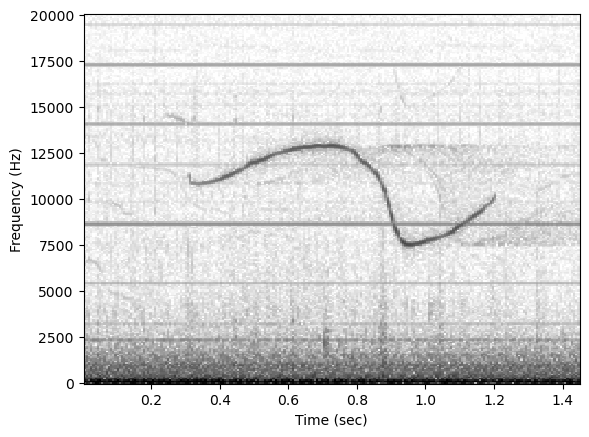

In [5]:
# Function to process audio files
def process_audio_to_spectrogram(audio_path):
    try:
        audio = Audio.from_file(audio_path)  # Load audio
        spec = Spectrogram.from_audio(audio)  # Convert to spectrogram
        return spec
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

# Example: Convert first audio file
sample_audio = df["SegmentPath"].iloc[751]  # Use segment path for consistency
sample_label = df["Class"].iloc[751]  # Get the class label
sample_spectrogram = process_audio_to_spectrogram(sample_audio)

# Display the spectrogram
if sample_spectrogram:
    print(f"Class: {sample_label}")
    sample_spectrogram.plot()

## Splitting the data

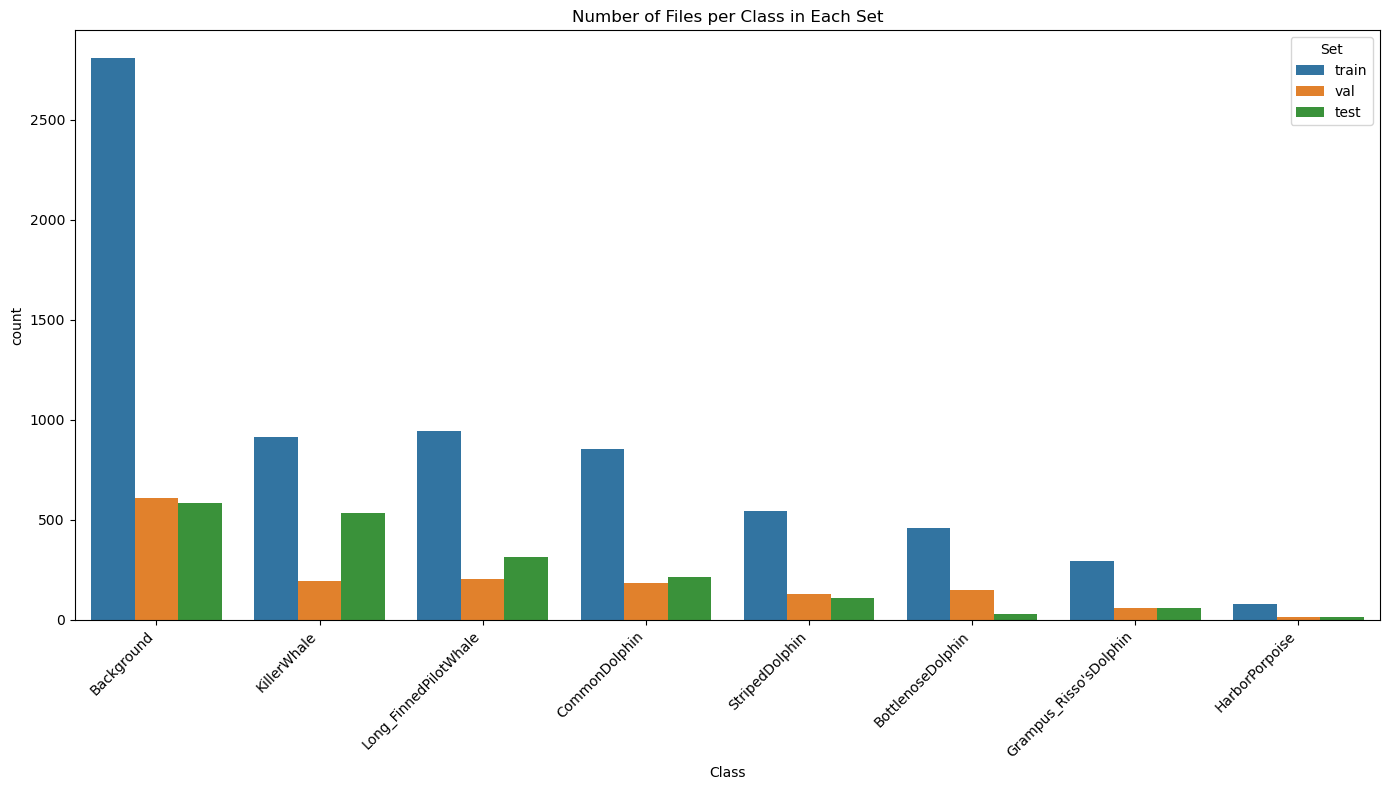

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create train-test split (80-20)
train_df = df[df["Subset"] == "train"]
val_df = df[df["Subset"] == "val"]
test_df = df[df["Subset"] == "test"]

# Plot count per class, each subset is a bar for each class (train, val and test)
class_counts = df['Class'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(14, 8))
sns.countplot(data=df, x='Class', hue='Subset', order=class_counts.index)
plt.title('Number of Files per Class in Each Set')
plt.xticks(rotation=45, ha='right', fontsize=10)  # Adjust fontsize and alignment
plt.legend(title='Set')
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()

## OpenSoundScape Dataset

In [7]:
def load_labels_from_df(df):
    # Listar las clases únicas
    class_labels = sorted(df['Class'].unique())

    # Crear una nueva lista para los resultados
    data = []

    # Iterar sobre las filas del dataframe original
    for _, row in df.iterrows():
        # Extraer la ruta de archivo y la duración
        file_path = row['SegmentPath']
        duration = round(row['Duration'], 2) - 0.03
        start_time = 0
        end_time = start_time + duration
        
        # Crear una fila con la información de tiempo y clases
        row_data = {
            'file': file_path,
            'start_time': start_time,
            'end_time': end_time
        }
        
        # Marcar las clases correspondientes en cada intervalo
        for label in class_labels:
            # Si el intervalo pertenece a esta clase, marcamos True, sino False
            if row['Class'] == label:
                row_data[label] = True
            else:
                row_data[label] = False
        
        # Agregar la fila generada al conjunto de datos
        data.append(row_data)

    # Convertir la lista de filas a un DataFrame
    df_labels = pd.DataFrame(data)

    # Reorganizar las columnas para tener file, start_time, end_time seguidos de las clases
    df_labels = df_labels[['file', 'start_time', 'end_time'] + list(class_labels)]

    # Establecer el índice como 'file', 'start_time', y 'end_time'
    df_labels.set_index(['file', 'start_time', 'end_time'], inplace=True)

    return df_labels

train_labels = load_labels_from_df(train_df)
val_labels = load_labels_from_df(val_df)
test_labels = load_labels_from_df(test_df)

In [8]:
train_labels

,,,Background,BottlenoseDolphin,CommonDolphin,Grampus_Risso'sDolphin,HarborPorpoise,KillerWhale,Long_FinnedPilotWhale,StripedDolphin
file,start_time,end_time,,,,,,,,
../../Dataset/Audios/Watkins Marine Mammals/Segmented/BottlenoseDolphin/90033004_180.0_183.0.wav,0,2.97,False,True,False,False,False,False,False,False
../../Dataset/Audios/Watkins Marine Mammals/Segmented/BottlenoseDolphin/90033005_66.0_69.0.wav,0,2.97,False,True,False,False,False,False,False,False
../../Dataset/Audios/Watkins Marine Mammals/Segmented/BottlenoseDolphin/90033004_207.0_210.0.wav,0,2.97,False,True,False,False,False,False,False,False
../../Dataset/Audios/Watkins Marine Mammals/Segmented/BottlenoseDolphin/90033004_198.0_201.0.wav,0,2.97,False,True,False,False,False,False,False,False
../../Dataset/Audios/Watkins Marine Mammals/Segmented/BottlenoseDolphin/90033003_21.0_24.0.wav,0,2.97,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
../../Dataset/Audios/CIRCE/Long_FinnedPilotWhale/GM_00105.wav,0,1.17,False,False,False,False,False,False,True,False
../../Dataset/Audios/CIRCE/Long_FinnedPilotWhale/GM_00053.wav,0,0.63,False,False,False,False,False,False,True,False
../../Dataset/Audios/CIRCE/Long_FinnedPilotWhale/GM_00143.wav,0,0.95,False,False,False,False,False,False,True,False


## Train Model

In [9]:
bmz.list_models()

Using cache found in /home/gruncrow/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_0.11.0.dev1
2025-02-21 09:56:50.683541: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740128210.816958   74818 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740128210.854579   74818 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-21 09:56:51.223546: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


['BirdNET',
 'HawkEars',
 'MissingHawkearsDependency',
 'MissingTFDependency',
 'Perch',
 'SeparationModel',
 'YAMNet',
 'rana_sierrae_cnn']

In [10]:
# Load a pretrained model
perch = bmz.load('Perch')  # or bmz.load('Perch')

Using cache found in /home/gruncrow/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_0.11.0.dev1
2025-02-21 09:57:03.635177: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-02-21 09:57:08.746777: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 55971840 exceeds 10% of free system memory.
/home/gruncrow/anaconda3/envs/opensoundscape/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:621: UserWarning: 
                    This architecture is not listed in opensoundscape.ml.cnn_architectures.ARCH_DICT.
                    It will not be available for loading after saving the model with .save() (unless using pickle=True). 
                    To make it re-loadable, define a function that generates the architecture from arguments: (n_classes, n_channels) 
                    then use opensoundscape.ml.cnn_architectures.register_architecture() to 

In [11]:
emb_train = perch.embed(train_labels, return_dfs=False, batch_size=16, num_workers=0)

  0%|          | 0/431 [00:00<?, ?it/s]

I0000 00:00:1740128232.077391   74818 service.cc:148] XLA service 0x3cb17090 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740128232.078132   74818 service.cc:156]   StreamExecutor device (0): Host, Default Version
2025-02-21 09:57:12.715679: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1740128232.791002   74818 assert_op.cc:38] Ignoring Assert operator jax2tf_infer_fn_/assert_equal_1/Assert/AssertGuard/Assert
I0000 00:00:1740128238.007759   74818 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-02-21 09:57:18.026824: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 246837248 exceeds 10% of free system memory.
2025-02-21 09:57:22.650962: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Alloca

In [12]:
emb_val = perch.embed(val_labels, return_dfs=False, batch_size=16, num_workers=0)

  0%|          | 0/97 [00:00<?, ?it/s]

/home/gruncrow/anaconda3/envs/opensoundscape/lib/python3.10/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 0.70996875 sec instead of 0.71 sec
  warnings.warn(error_msg)
/home/gruncrow/anaconda3/envs/opensoundscape/lib/python3.10/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 0.68996875 sec instead of 0.69 sec
  warnings.warn(error_msg)
/home/gruncrow/anaconda3/envs/opensoundscape/lib/python3.10/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 1.38996875 sec instead of 1.39 sec
  warnings.warn(error_msg)
/home/gruncrow/anaconda3/envs/opensoundscape/lib/python3.10/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 0.56996875 sec instead of 0.57 sec
  warnings.warn(error_msg)
/home/gruncrow/anaconda3/envs/opensoundscape/lib/python3.10/site-packages/opensoundscape

In [13]:
# calculate test embeddings
emb_test = perch.embed(test_labels, return_dfs=False, batch_size=16, num_workers=0)

  0%|          | 0/116 [00:00<?, ?it/s]

/home/gruncrow/anaconda3/envs/opensoundscape/lib/python3.10/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 2.3699375 sec instead of 2.37 sec
  warnings.warn(error_msg)
/home/gruncrow/anaconda3/envs/opensoundscape/lib/python3.10/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 1.25996875 sec instead of 1.26 sec
  warnings.warn(error_msg)
/home/gruncrow/anaconda3/envs/opensoundscape/lib/python3.10/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 2.9699375 sec instead of 2.97 sec
  warnings.warn(error_msg)
/home/gruncrow/anaconda3/envs/opensoundscape/lib/python3.10/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 1.43996875 sec instead of 1.44 sec
  warnings.warn(error_msg)
/home/gruncrow/anaconda3/envs/opensoundscape/lib/python3.10/site-packages/opensoundscape/a

## Change model head

In [14]:
perch.change_classes(sorted(df['Class'].unique()))

In [15]:
quick_fit(perch.network, emb_train, train_labels.values, emb_val, val_labels.values,steps=1000)

Epoch 100/1000, Loss: 0.23225590586662292, Val Loss: 0.23955580592155457
val AU ROC: 0.515
val MAP: 0.515
Epoch 200/1000, Loss: 0.18626099824905396, Val Loss: 0.1924053281545639
val AU ROC: 0.595
val MAP: 0.595
Epoch 300/1000, Loss: 0.161420539021492, Val Loss: 0.16781830787658691
val AU ROC: 0.652
val MAP: 0.652
Epoch 400/1000, Loss: 0.14477691054344177, Val Loss: 0.15198096632957458
val AU ROC: 0.687
val MAP: 0.687
Epoch 500/1000, Loss: 0.13242706656455994, Val Loss: 0.1405801773071289
val AU ROC: 0.709
val MAP: 0.709
Epoch 600/1000, Loss: 0.122706338763237, Val Loss: 0.13183532655239105
val AU ROC: 0.728
val MAP: 0.728
Epoch 700/1000, Loss: 0.11474609375, Val Loss: 0.12484407424926758
val AU ROC: 0.744
val MAP: 0.744
Epoch 800/1000, Loss: 0.10804169625043869, Val Loss: 0.11908871680498123
val AU ROC: 0.757
val MAP: 0.757
Epoch 900/1000, Loss: 0.10227759927511215, Val Loss: 0.11424650251865387
val AU ROC: 0.767
val MAP: 0.767
Epoch 1000/1000, Loss: 0.09724386036396027, Val Loss: 0.11

## Train new model head

In [16]:
# make predictions by passing the embeddings through the classifier
preds = perch.network(torch.tensor(emb_test).float()).detach().numpy()

array([0.99978562, 0.93432018, 0.97619677, 0.95775734, 0.92468944,
       0.96449046, 0.9629207 , 0.94833194])

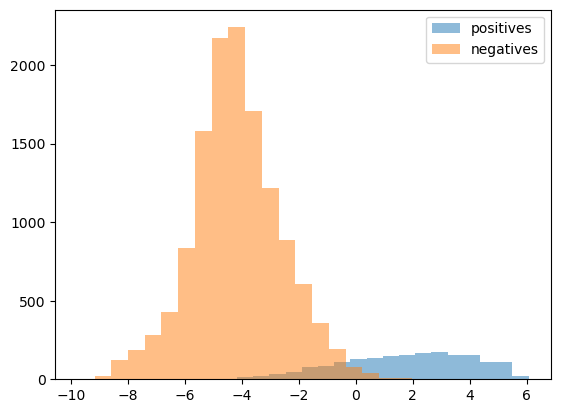

In [17]:
from sklearn.metrics import roc_auc_score

# plot histogram of scores for positive and negative clips
plt.hist(preds[test_labels==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[test_labels==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score(test_labels.values,preds,average=None)

In [18]:
# from each prediction, take the class with the highest probability
pred_classes = [perch.classes[i] for i in preds.argmax(axis=1)]

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Convert one-hot encoded test_labels to a list of class labels
true_classes = test_labels.idxmax(axis=1)  # Get class name with highest value (True)
# Generate classification report
report = classification_report(true_classes, pred_classes)
print(report)

                        precision    recall  f1-score   support

            Background       0.89      1.00      0.94       584
     BottlenoseDolphin       0.72      0.43      0.54        30
         CommonDolphin       0.77      0.86      0.81       212
Grampus_Risso'sDolphin       0.74      0.72      0.73        60
        HarborPorpoise       1.00      0.29      0.44        14
           KillerWhale       0.92      0.82      0.86       532
 Long_FinnedPilotWhale       0.86      0.84      0.85       312
        StripedDolphin       0.80      0.73      0.76       110

              accuracy                           0.87      1854
             macro avg       0.84      0.71      0.74      1854
          weighted avg       0.87      0.87      0.86      1854



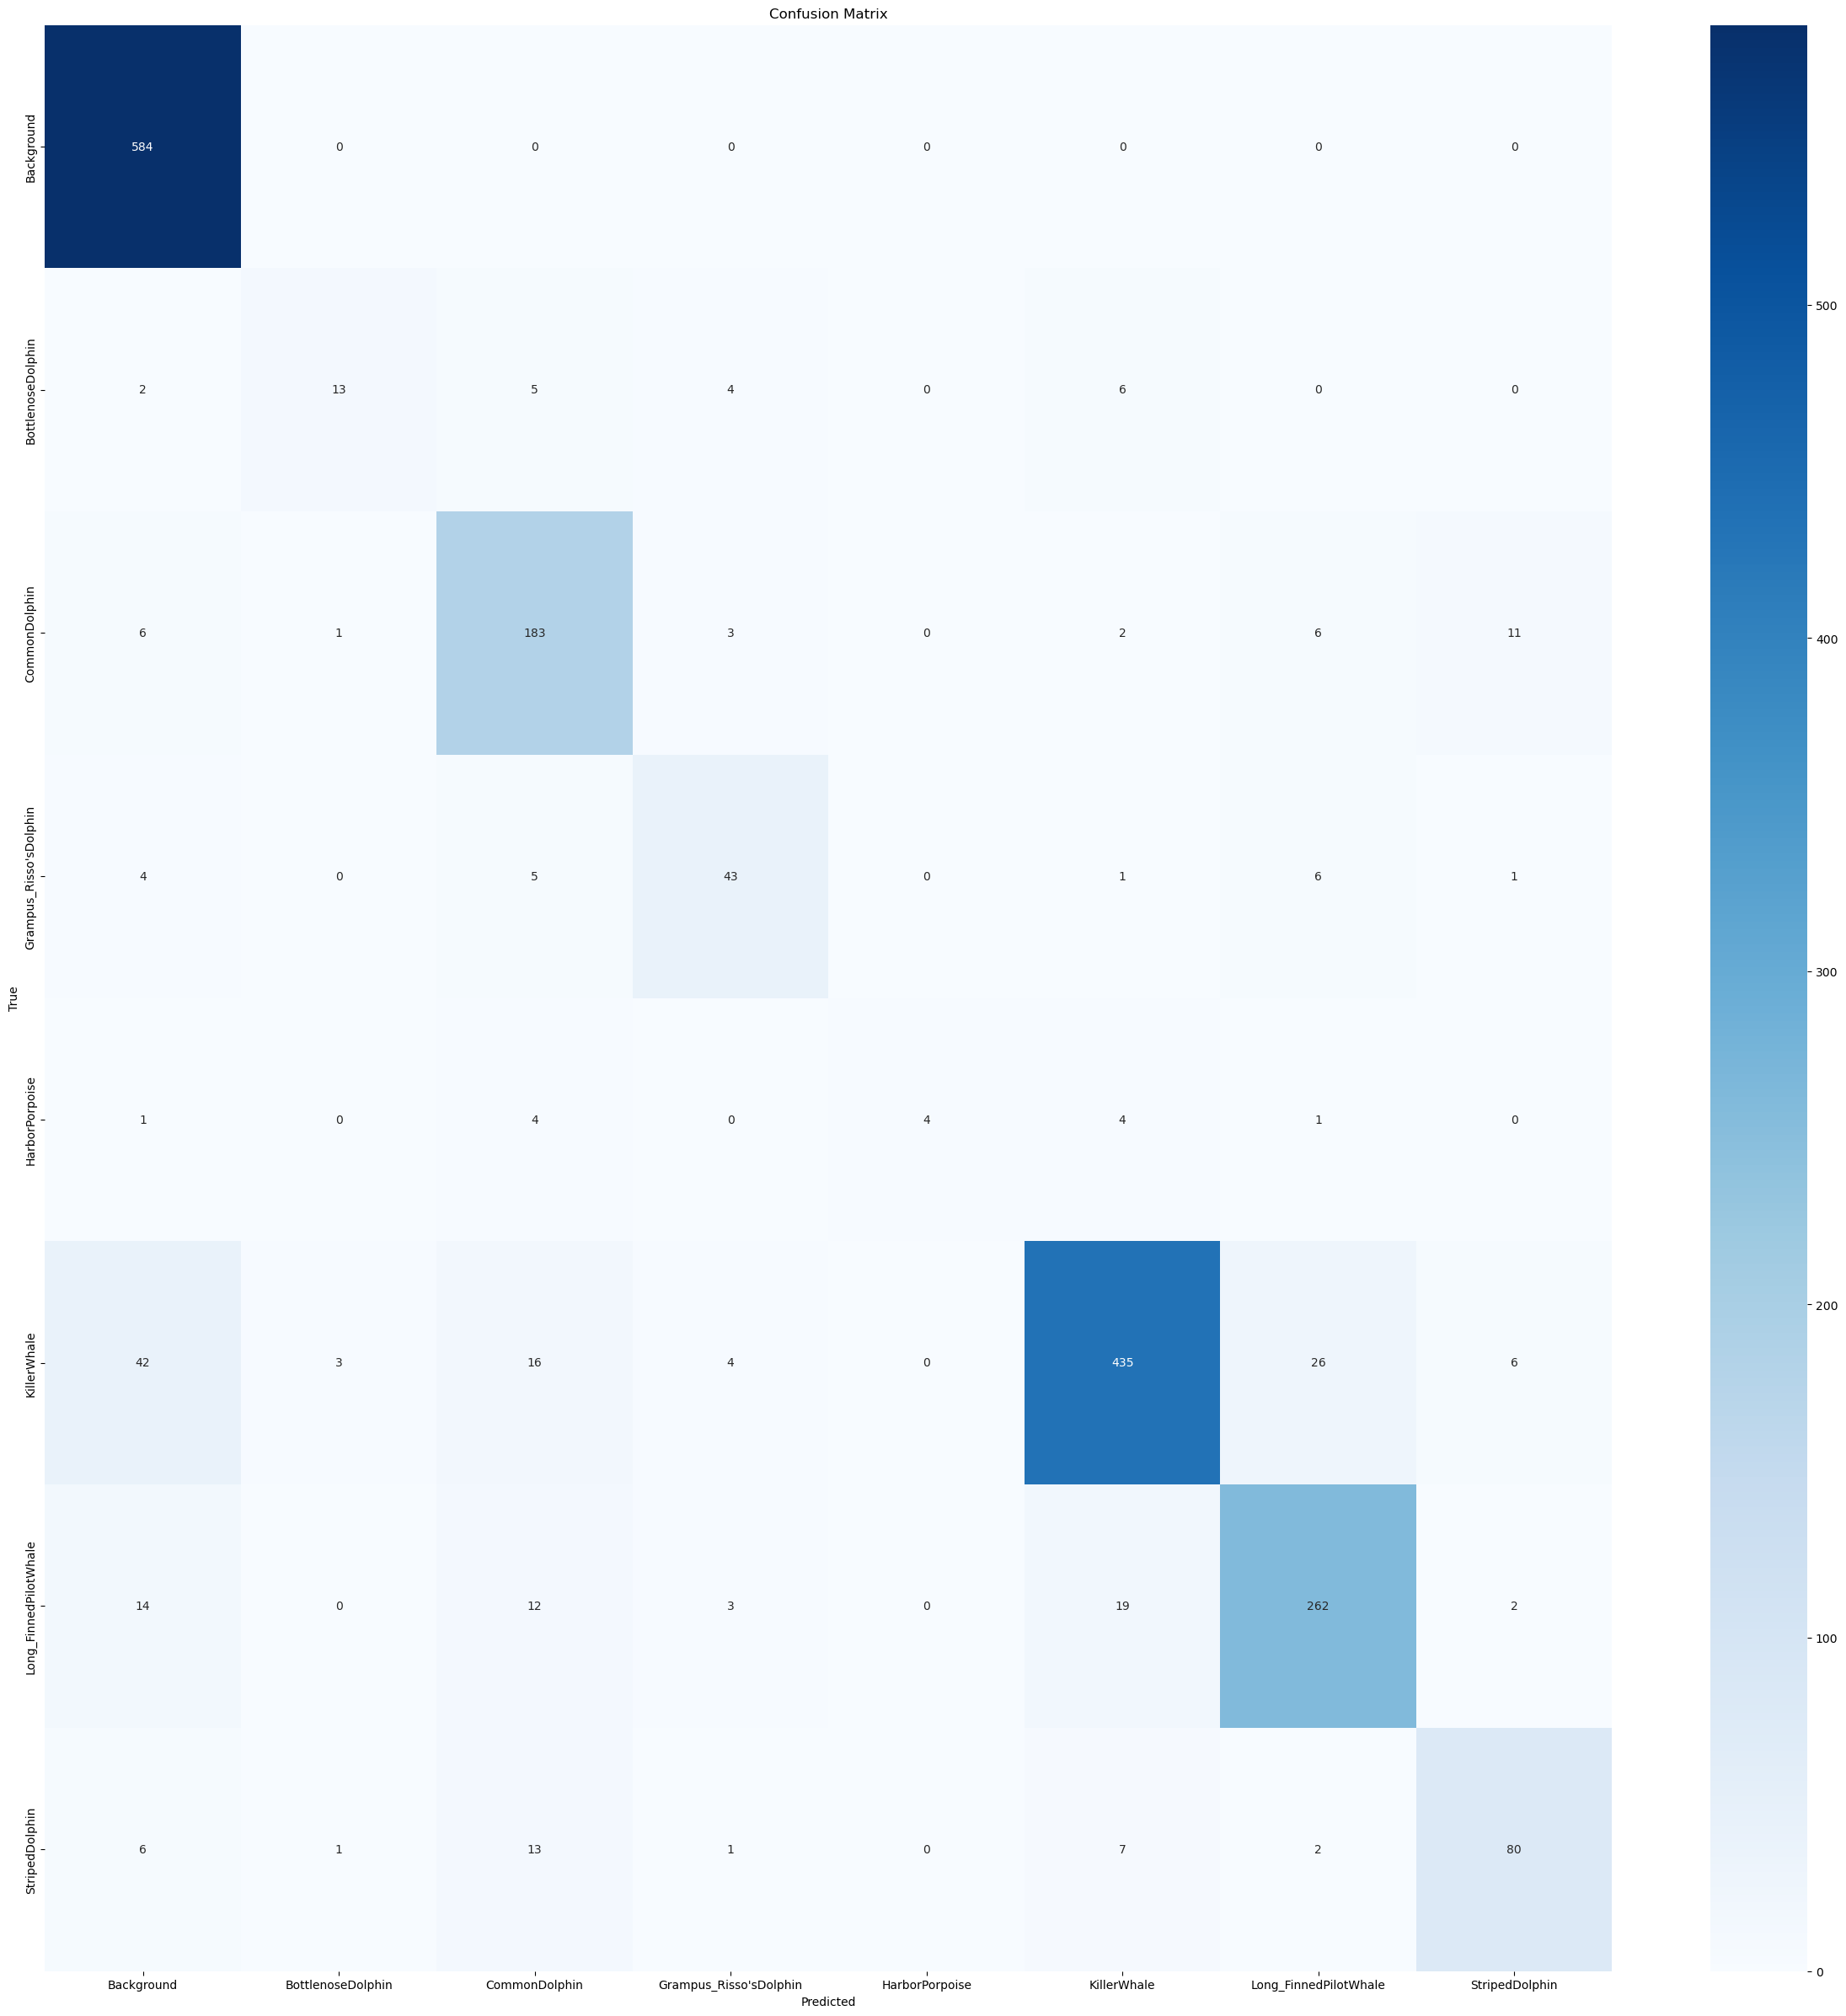

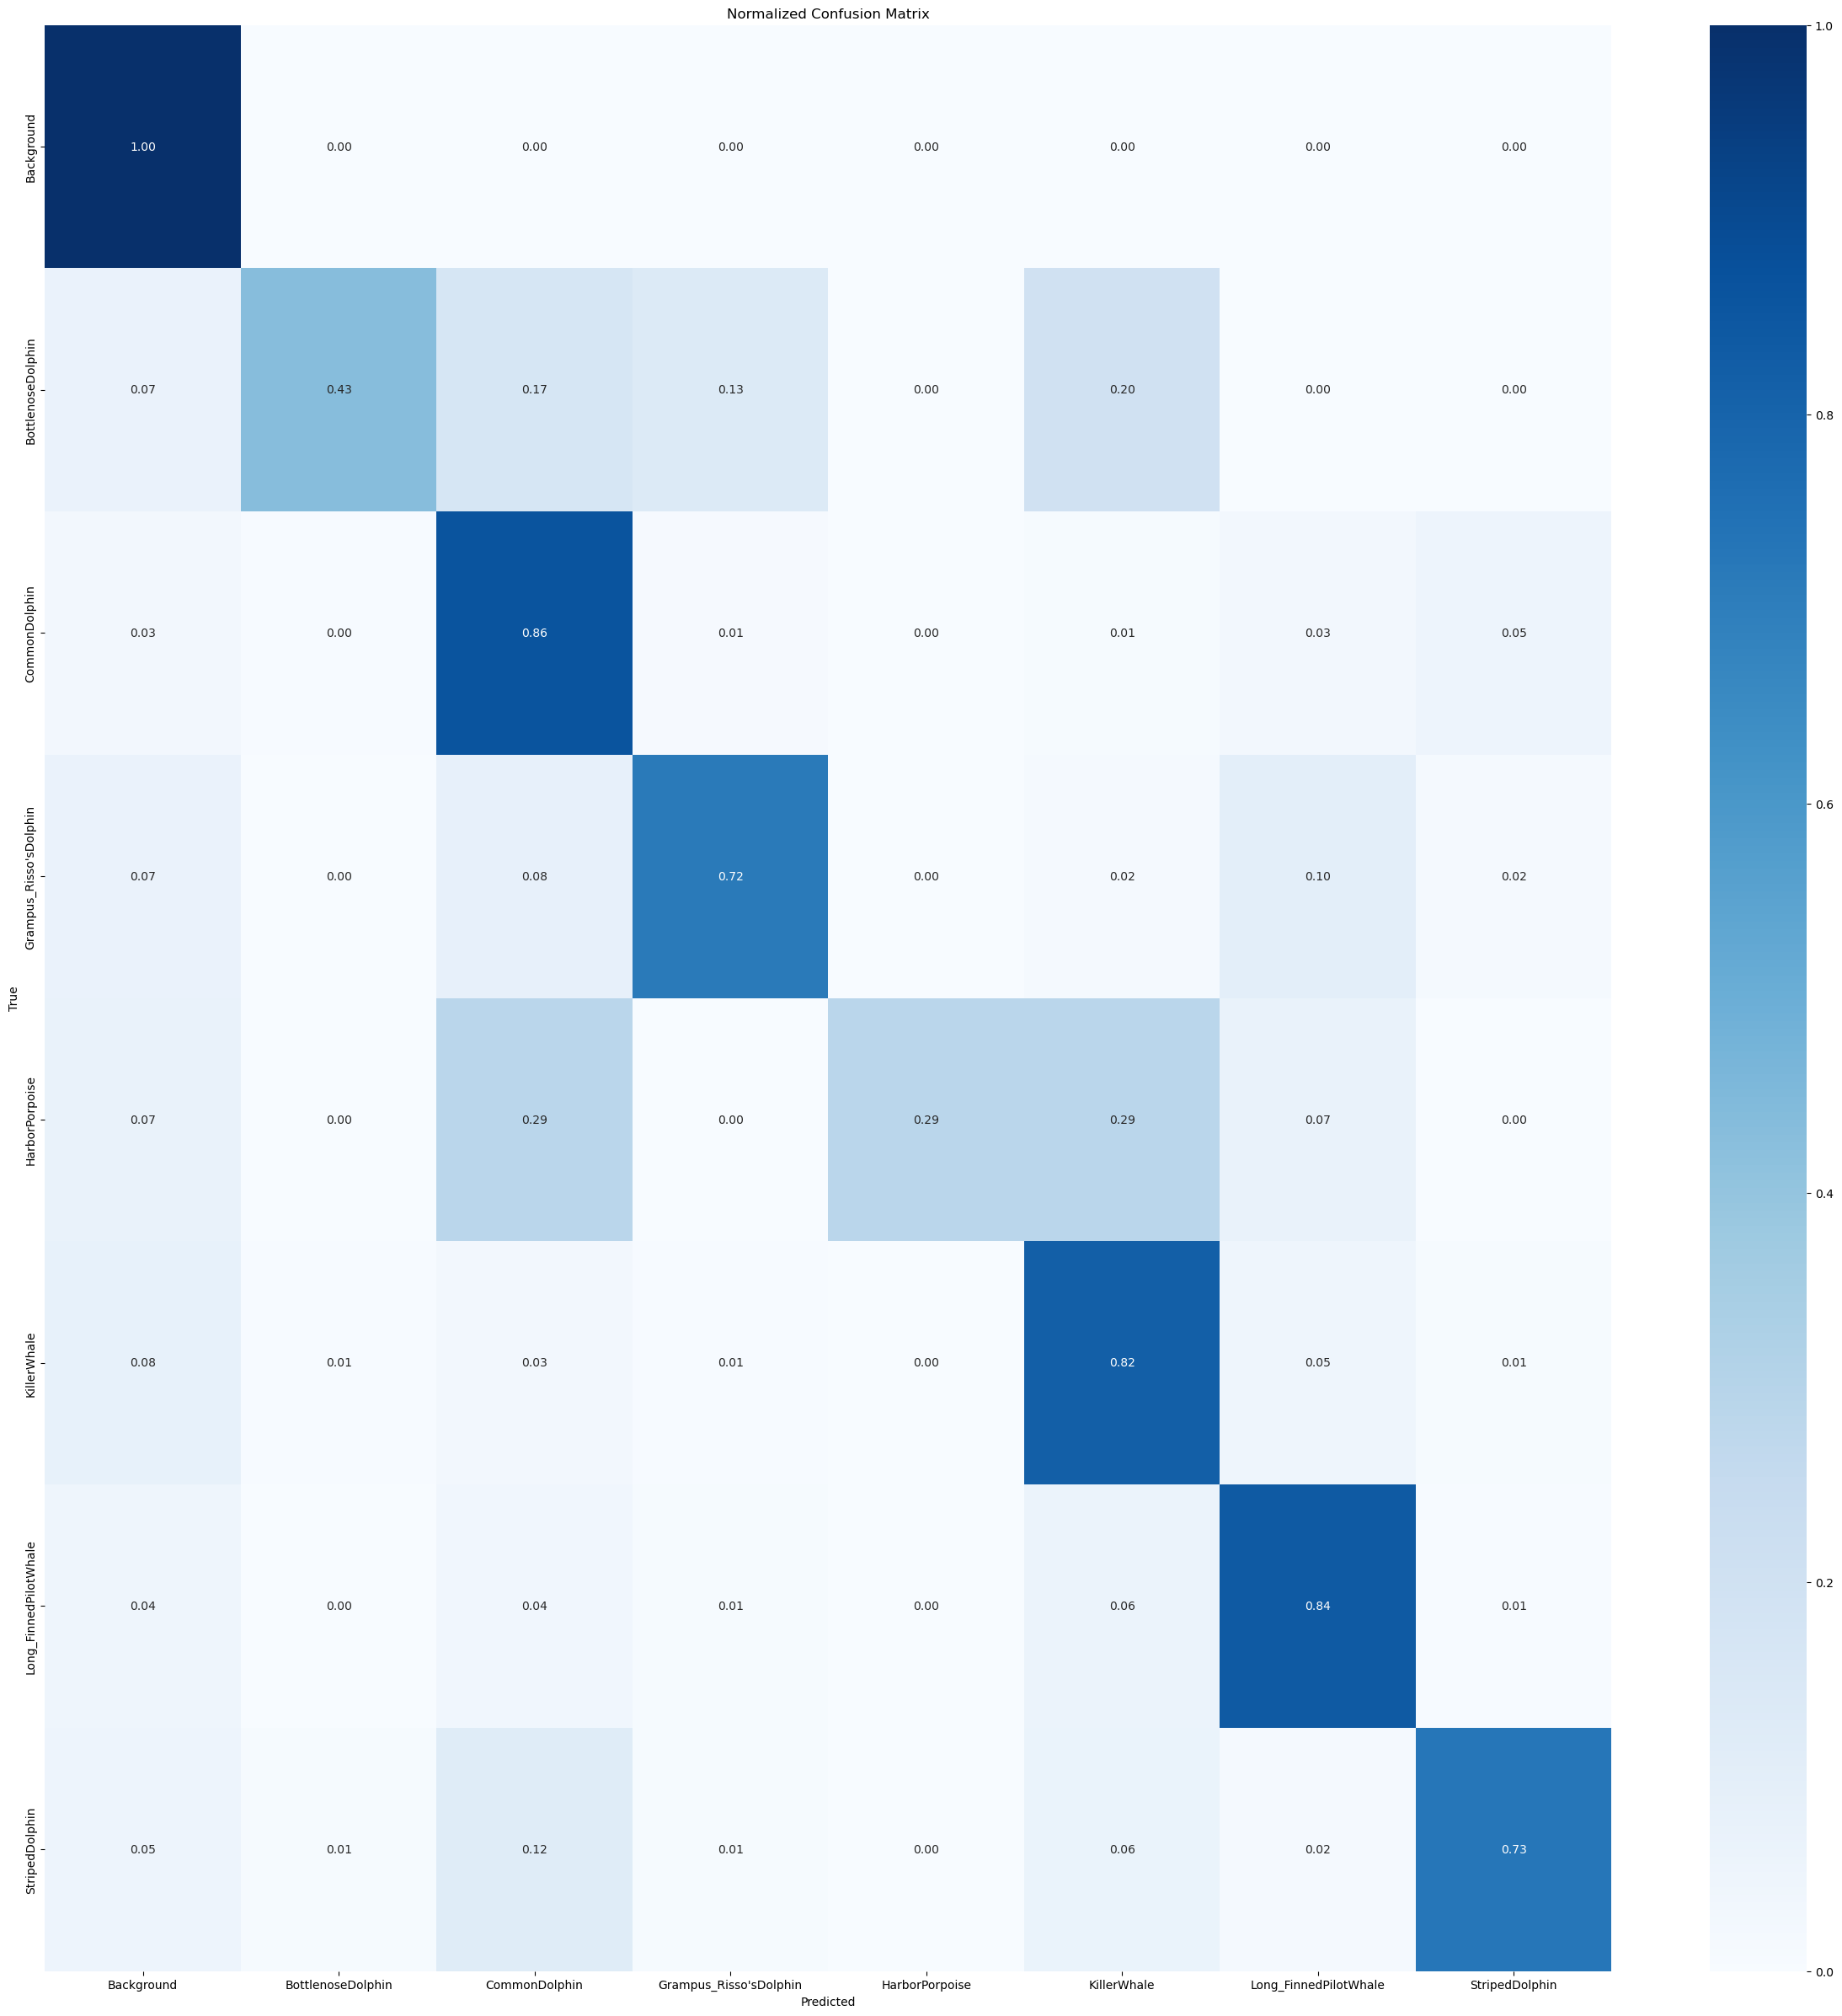

In [20]:
# Plot confusion matrix
cm = confusion_matrix(true_classes, pred_classes, labels=test_labels.columns)
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_labels.columns, yticklabels=test_labels.columns)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

import numpy as np

# Normalized by rows
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(30, 30))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=test_labels.columns, yticklabels=test_labels.columns)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [21]:
accuracy = accuracy_score(true_classes, pred_classes)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8652


In [22]:
from sklearn.metrics import f1_score

macro_f1 = f1_score(true_classes, pred_classes, average="macro")
weighted_f1 = f1_score(true_classes, pred_classes, average="weighted")

print(f"Macro F1-score: {macro_f1:.4f}")
print(f"Weighted F1-score: {weighted_f1:.4f}")


Macro F1-score: 0.7433
Weighted F1-score: 0.8614


In [23]:
from sklearn.metrics import roc_auc_score

# Assuming 'preds' contains raw probabilities from the classifier
auc_score = roc_auc_score(test_labels.values, preds, average="macro", multi_class="ovr")
print(f"Macro ROC-AUC Score: {auc_score:.4f}")


Macro ROC-AUC Score: 0.9586


### Use perch embeddings with RandomForest

In [24]:
# take a RandomForest classifier
from sklearn.ensemble import RandomForestClassifier

# create several experiments for RandomForest classifier and select the best one in validation
n_estimators = [10, 50, 100, 200]
max_depth = [10, 20, 50]
best_score = 0
best_clf = None

for n in n_estimators:
    for d in max_depth:
        clf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=42)
        clf.fit(emb_train, train_labels.values)
        preds = clf.predict(emb_val)
        # score = macro average f1
        score = f1_score(val_labels.values.argmax(axis=1), preds.argmax(axis=1), average='macro')
        if score > best_score:
            best_score = score
            best_clf = clf

# print the best parameters
print(best_clf)

# make predictions on the validation set
preds = best_clf.predict(emb_test)

RandomForestClassifier(max_depth=50, random_state=42)


/home/gruncrow/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gruncrow/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gruncrow/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                        precision    recall  f1-score   support

            Background       0.46      1.00      0.63       584
     BottlenoseDolphin       0.00      0.00      0.00        30
         CommonDolphin       0.99      0.42      0.59       212
Grampus_Risso'sDolphin       1.00      0.27      0.42        60
        HarborPorpoise       1.00      0.14      0.25        14
           KillerWhale       1.00      0.56      0.72       532
 Long_FinnedPilotWhale       0.99      0.46      0.62       312
        StripedDolphin       1.00      0.38      0.55       110

              accuracy                           0.63      1854
             macro avg       0.81      0.40      0.47      1854
          weighted avg       0.81      0.63      0.63      1854



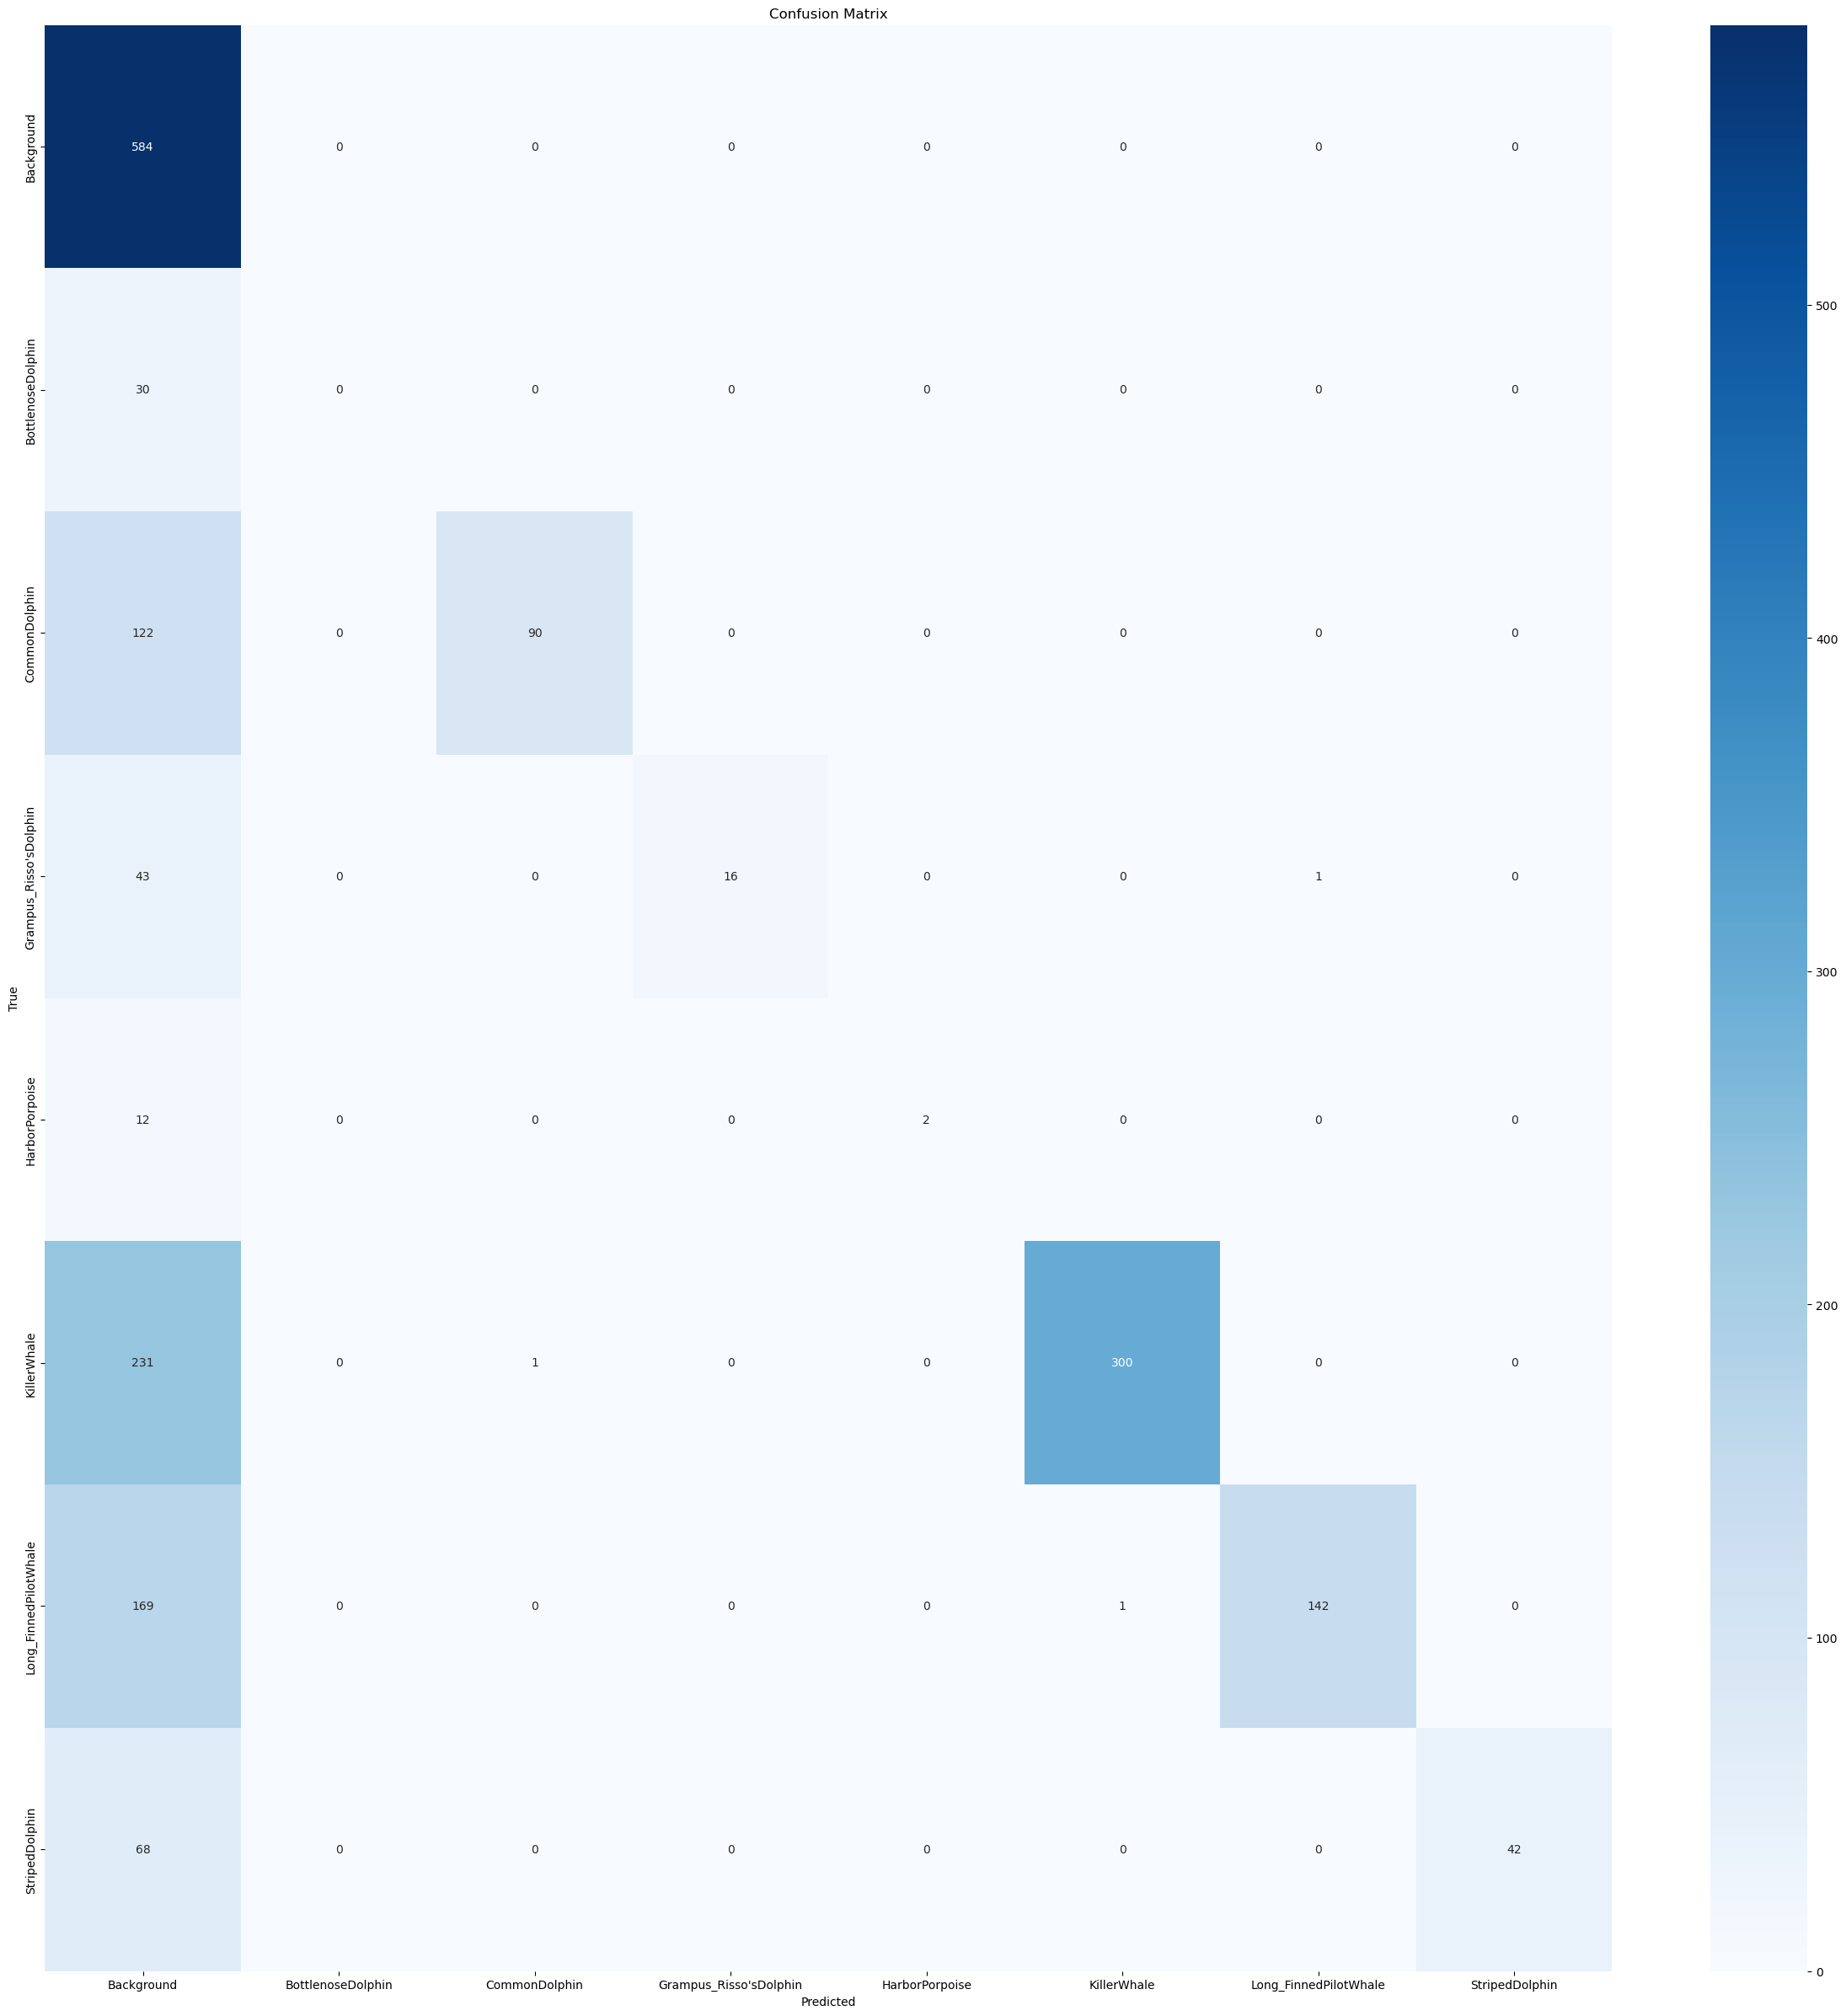

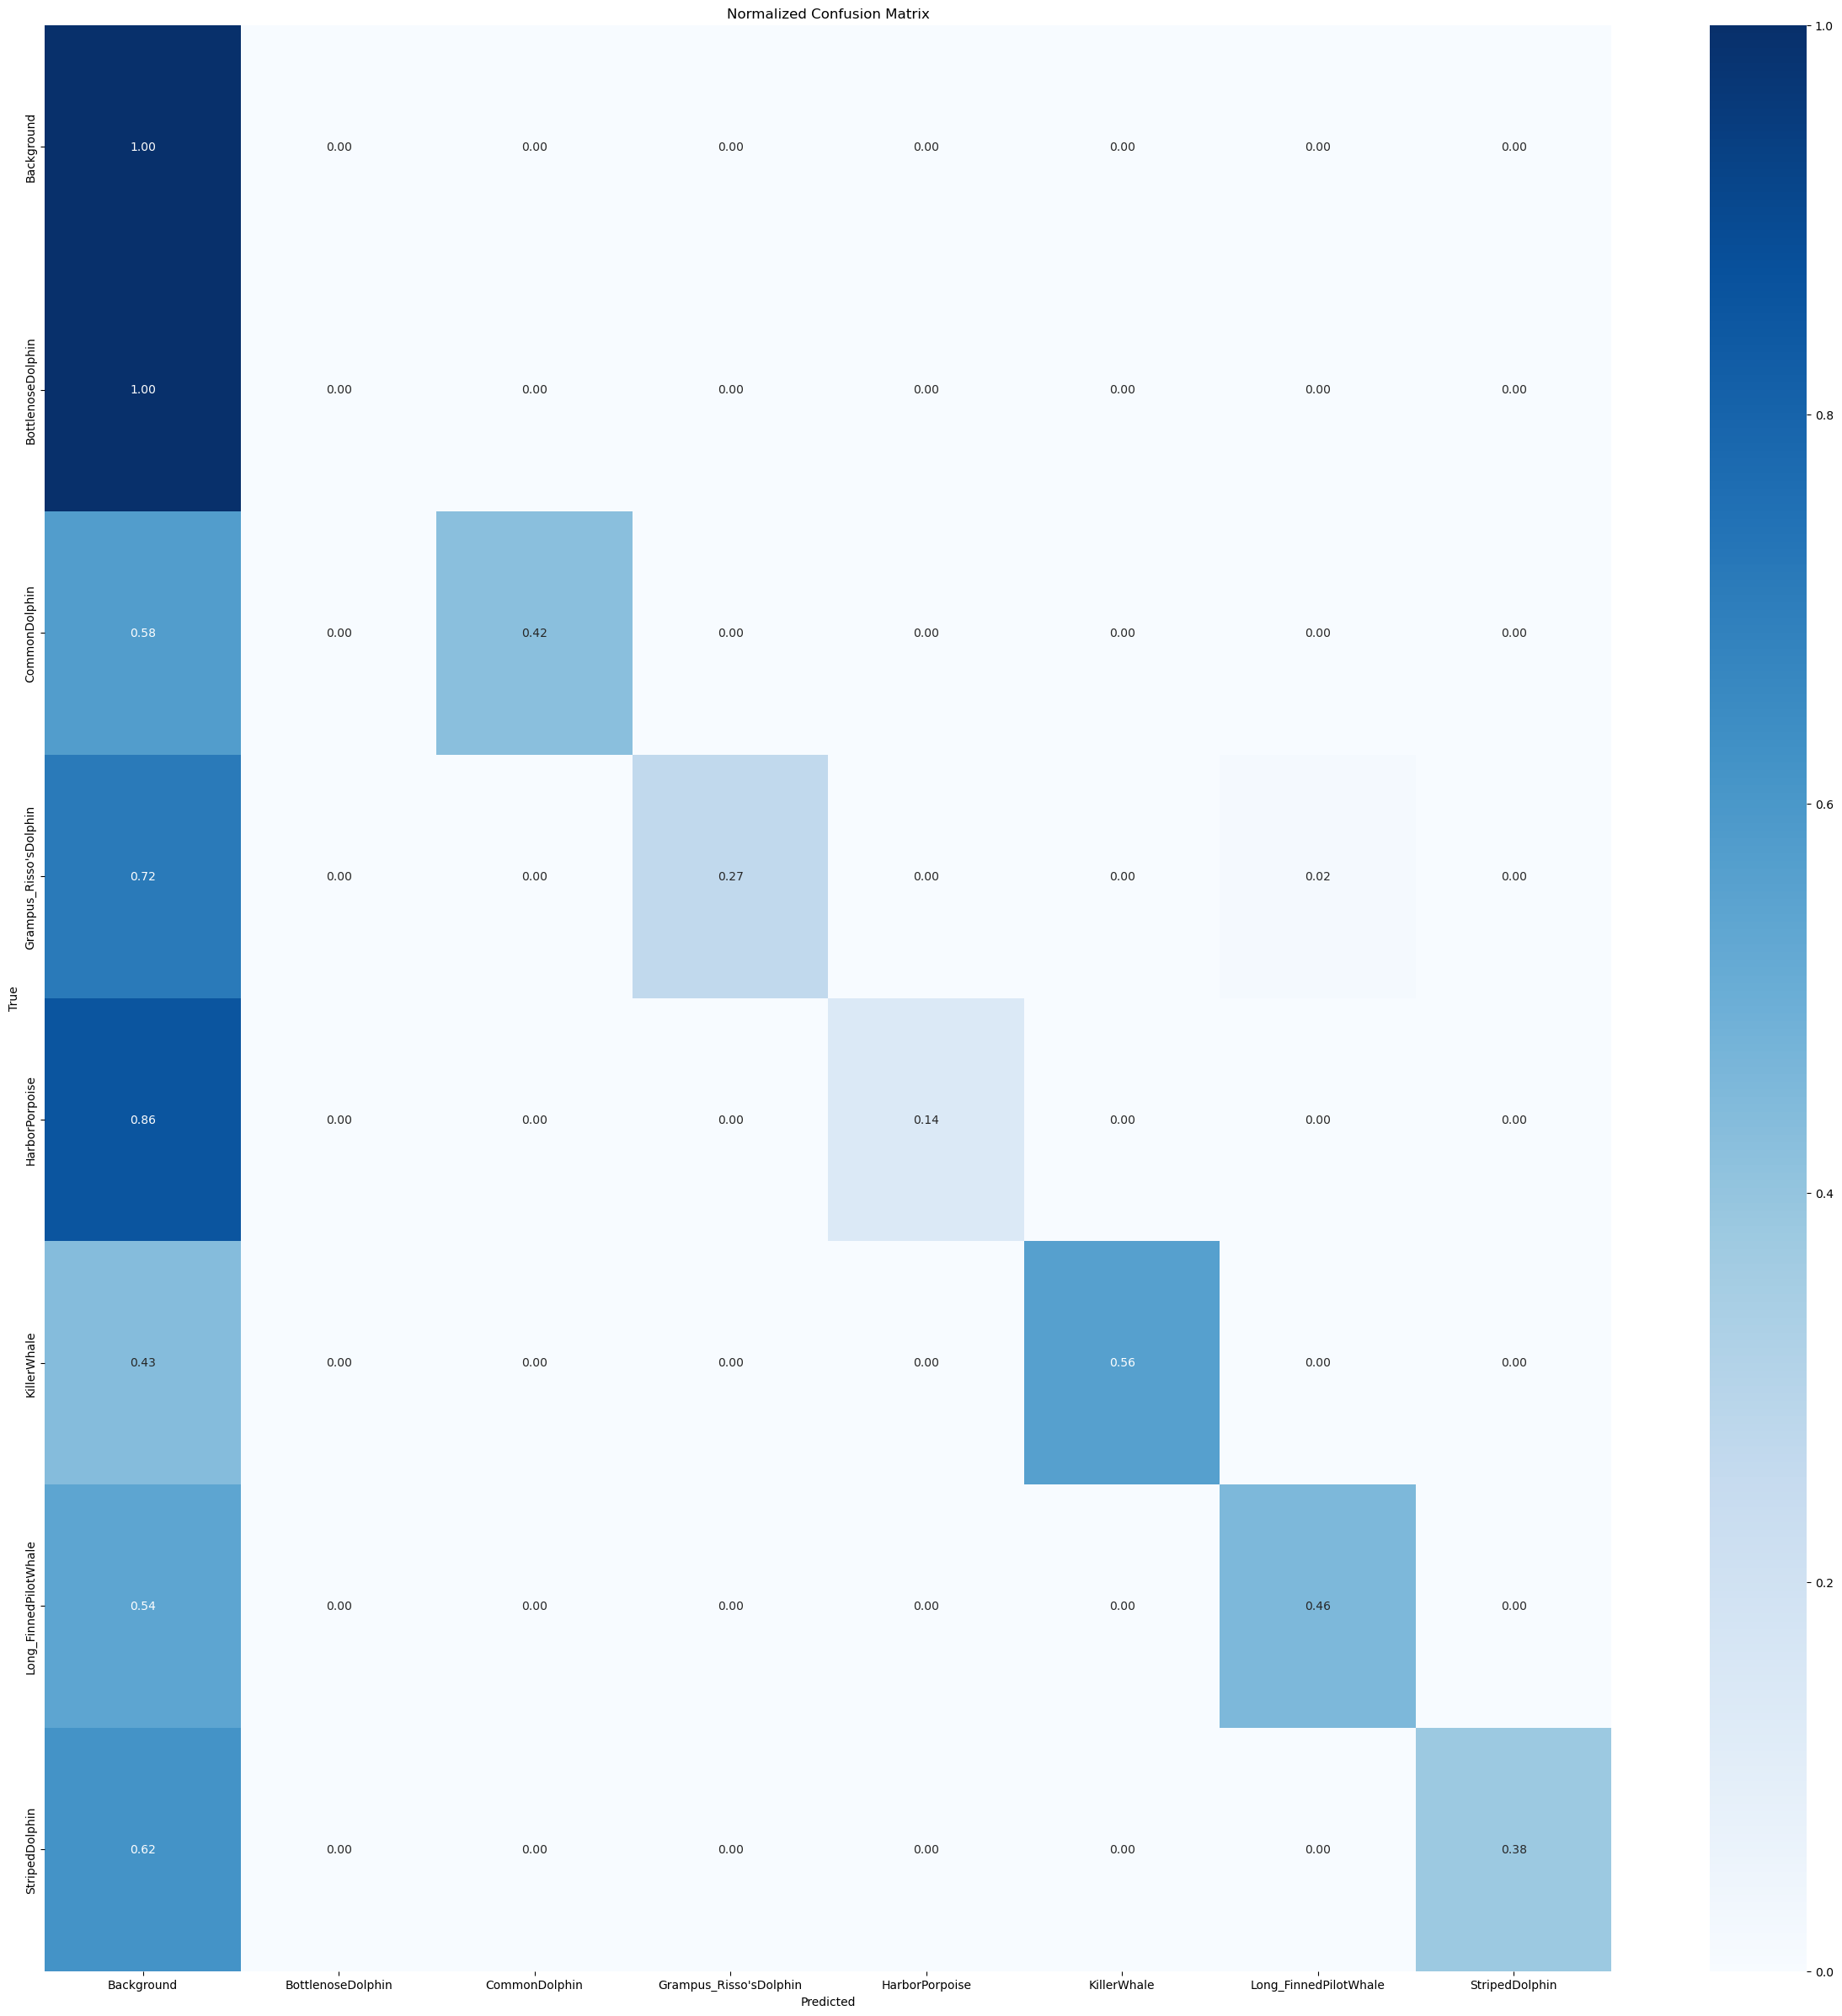

In [25]:
# from each prediction, take the class with the highest probability
pred_classes = [perch.classes[i] for i in preds.argmax(axis=1)]

# Convert one-hot encoded test_labels to a list of class labels
true_classes = test_labels.idxmax(axis=1)  # Get class name with highest value (True)
# Generate classification report
report = classification_report(true_classes, pred_classes)
print(report)

# Plot confusion matrix
cm = confusion_matrix(true_classes, pred_classes, labels=test_labels.columns)
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_labels.columns, yticklabels=test_labels.columns)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Normalized by rows
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(30, 30))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=test_labels.columns, yticklabels=test_labels.columns)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [26]:
from sklearn.metrics import f1_score

accuracy = accuracy_score(true_classes, pred_classes)
print(f"Accuracy: {accuracy:.4f}")

macro_f1 = f1_score(true_classes, pred_classes, average="macro")
weighted_f1 = f1_score(true_classes, pred_classes, average="weighted")

print(f"Macro F1-score: {macro_f1:.4f}")
print(f"Weighted F1-score: {weighted_f1:.4f}")


from sklearn.metrics import roc_auc_score

# Assuming 'preds' contains raw probabilities from the classifier
auc_score = roc_auc_score(test_labels.values, preds, average="macro", multi_class="ovr")
print(f"Macro ROC-AUC Score: {auc_score:.4f}")


Accuracy: 0.6343
Macro F1-score: 0.4745
Weighted F1-score: 0.6276
Macro ROC-AUC Score: 0.7014


### Use perch embeddings with SVC-RBF

In [27]:
# take a SVC-RBF classifier
from sklearn.svm import SVC

# create several experiments for SVC classifier and select the best one in validation
C_params = [1, 10, 100]
gamma = [0.1, 0.01, 0.001]
best_score = 0
best_clf = None

for c in C_params:
    for g in gamma:
        clf = SVC(kernel='rbf', C=c, gamma=g, probability=True, random_state=42)
        clf.fit(emb_train, train_labels.values.argmax(axis=1))
        preds = clf.predict(emb_val)
        # score = macro average f1
        score = f1_score(val_labels.values.argmax(axis=1), preds, average='macro')
        if score > best_score:
            best_score = score
            best_clf = clf

# print the best parameters
print(best_clf)

# make predictions on the test set
preds = best_clf.predict(emb_test)

SVC(C=100, gamma=0.1, probability=True, random_state=42)


                        precision    recall  f1-score   support

            Background       1.00      1.00      1.00       584
     BottlenoseDolphin       1.00      0.87      0.93        30
         CommonDolphin       0.84      0.94      0.88       212
Grampus_Risso'sDolphin       0.93      0.88      0.91        60
        HarborPorpoise       1.00      0.79      0.88        14
           KillerWhale       0.95      0.90      0.92       532
 Long_FinnedPilotWhale       0.88      0.91      0.90       312
        StripedDolphin       0.87      0.87      0.87       110

              accuracy                           0.93      1854
             macro avg       0.93      0.89      0.91      1854
          weighted avg       0.94      0.93      0.93      1854



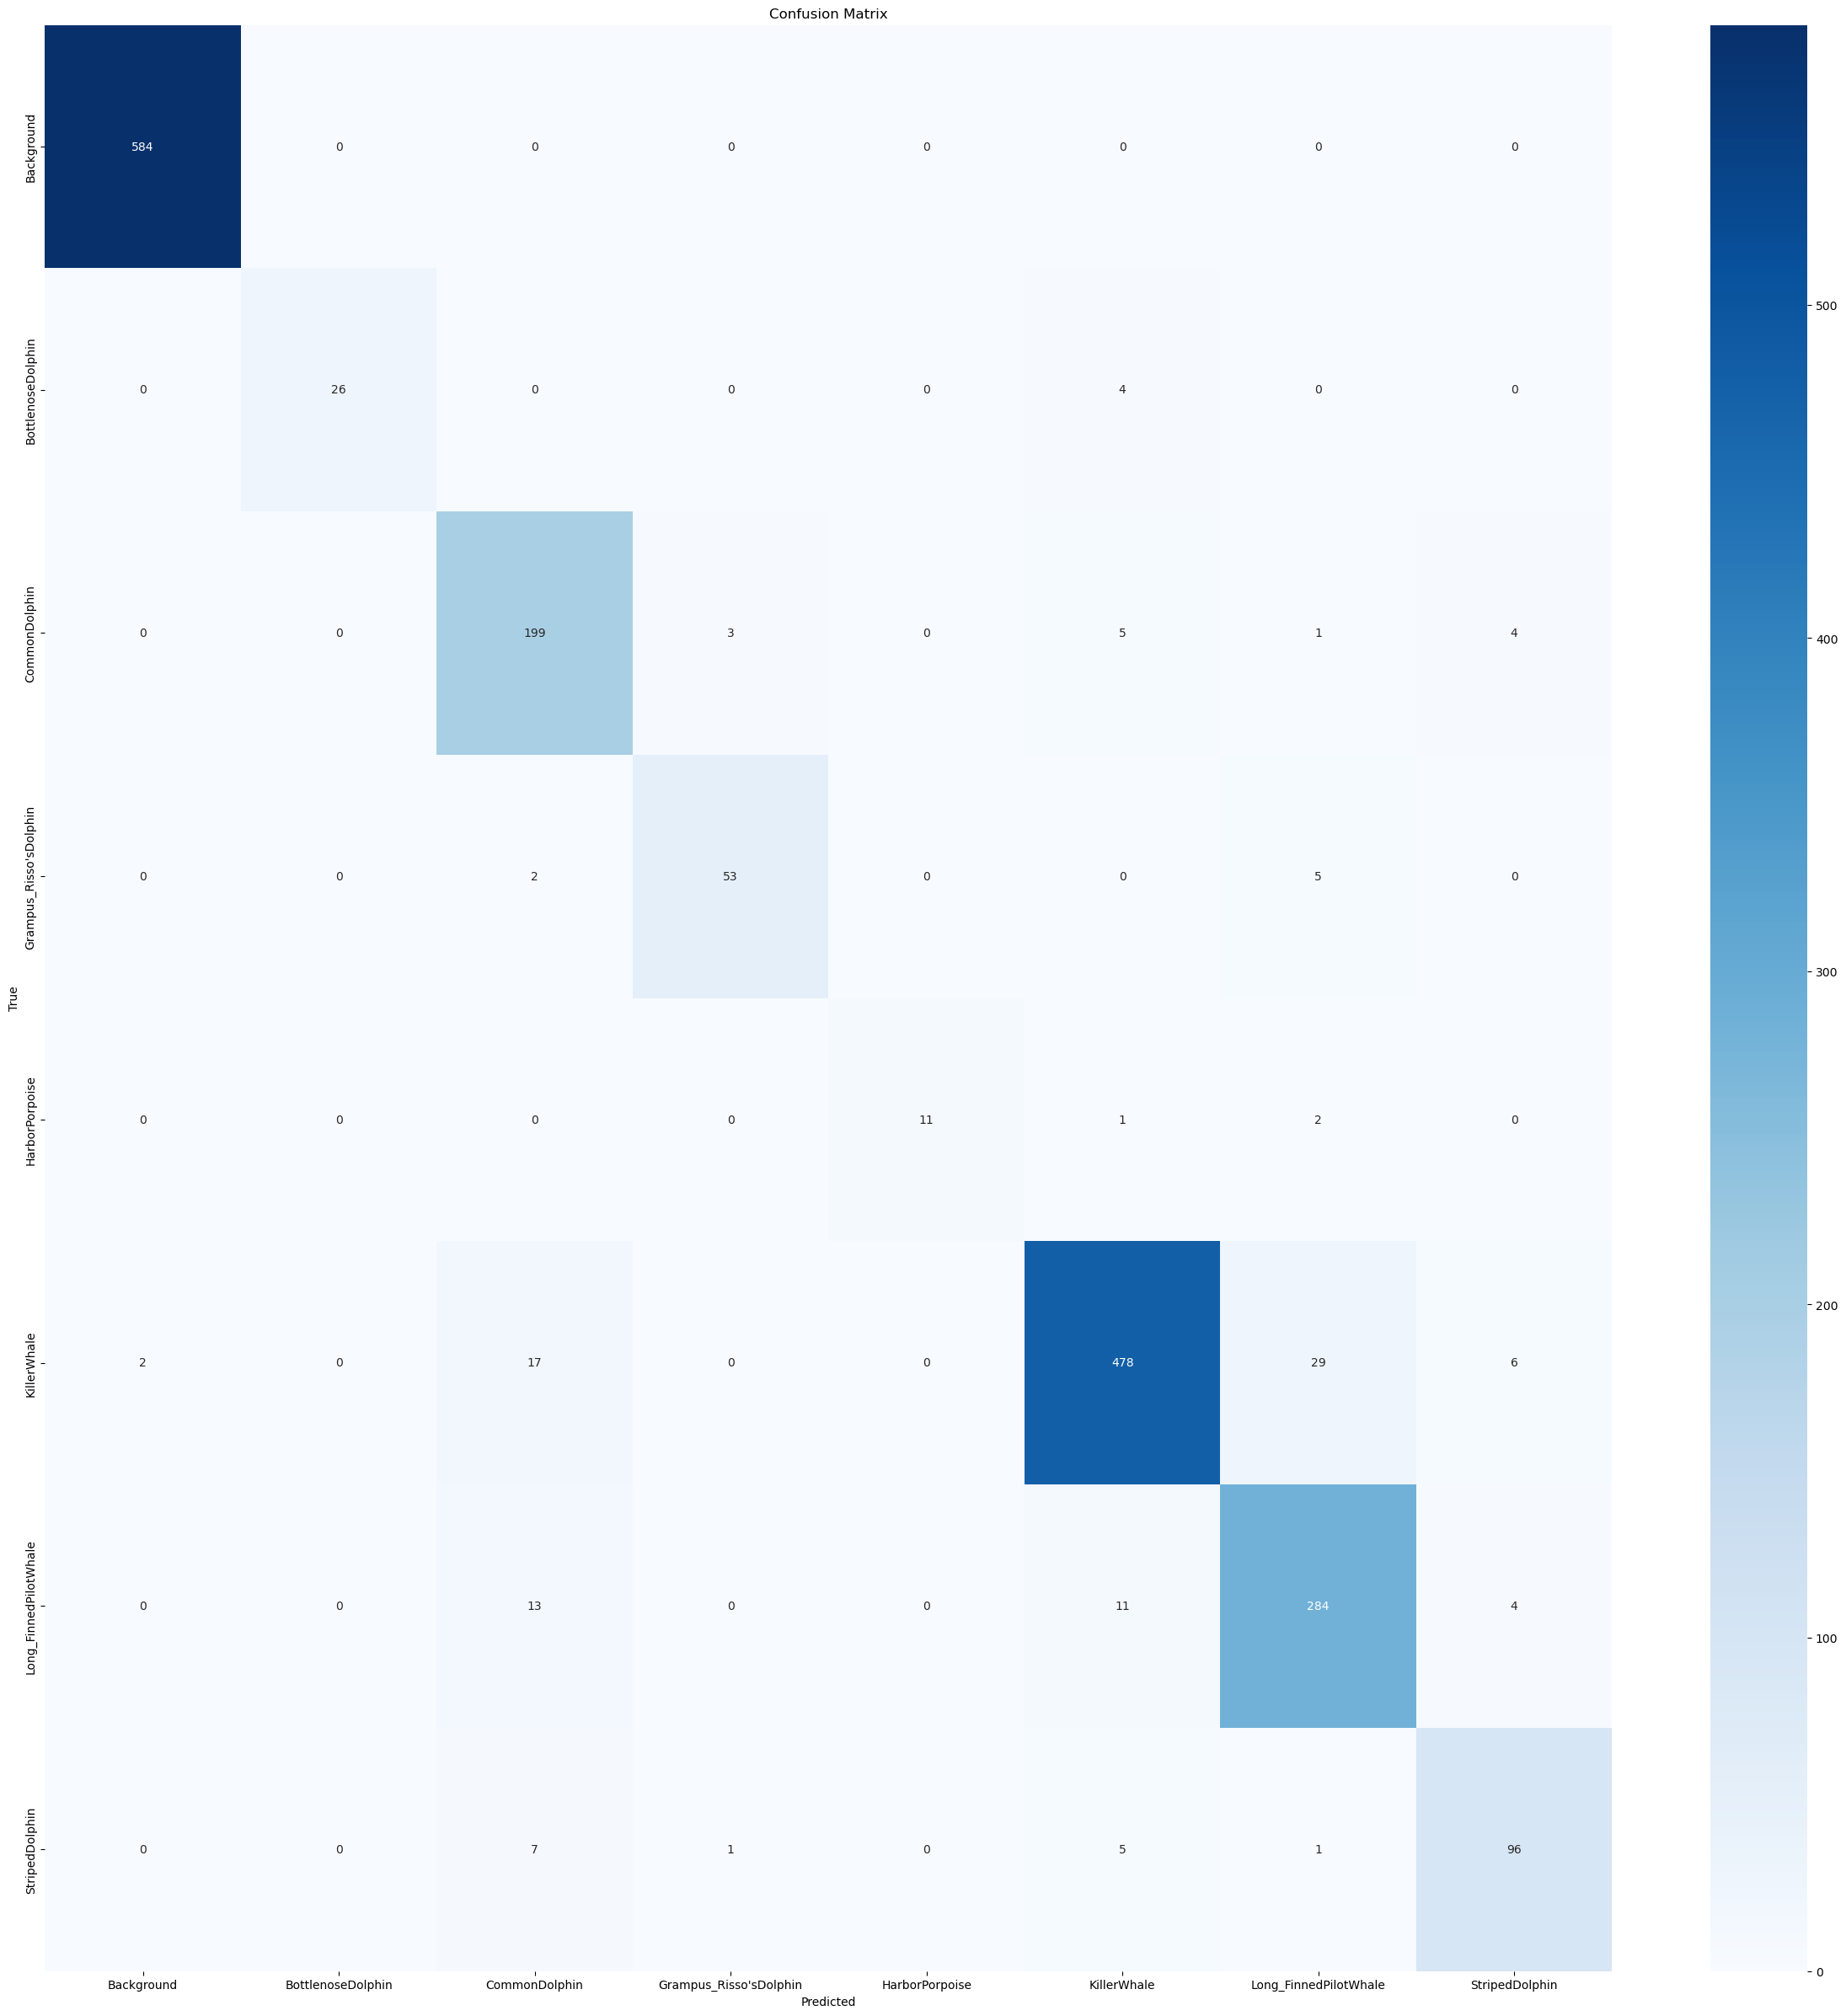

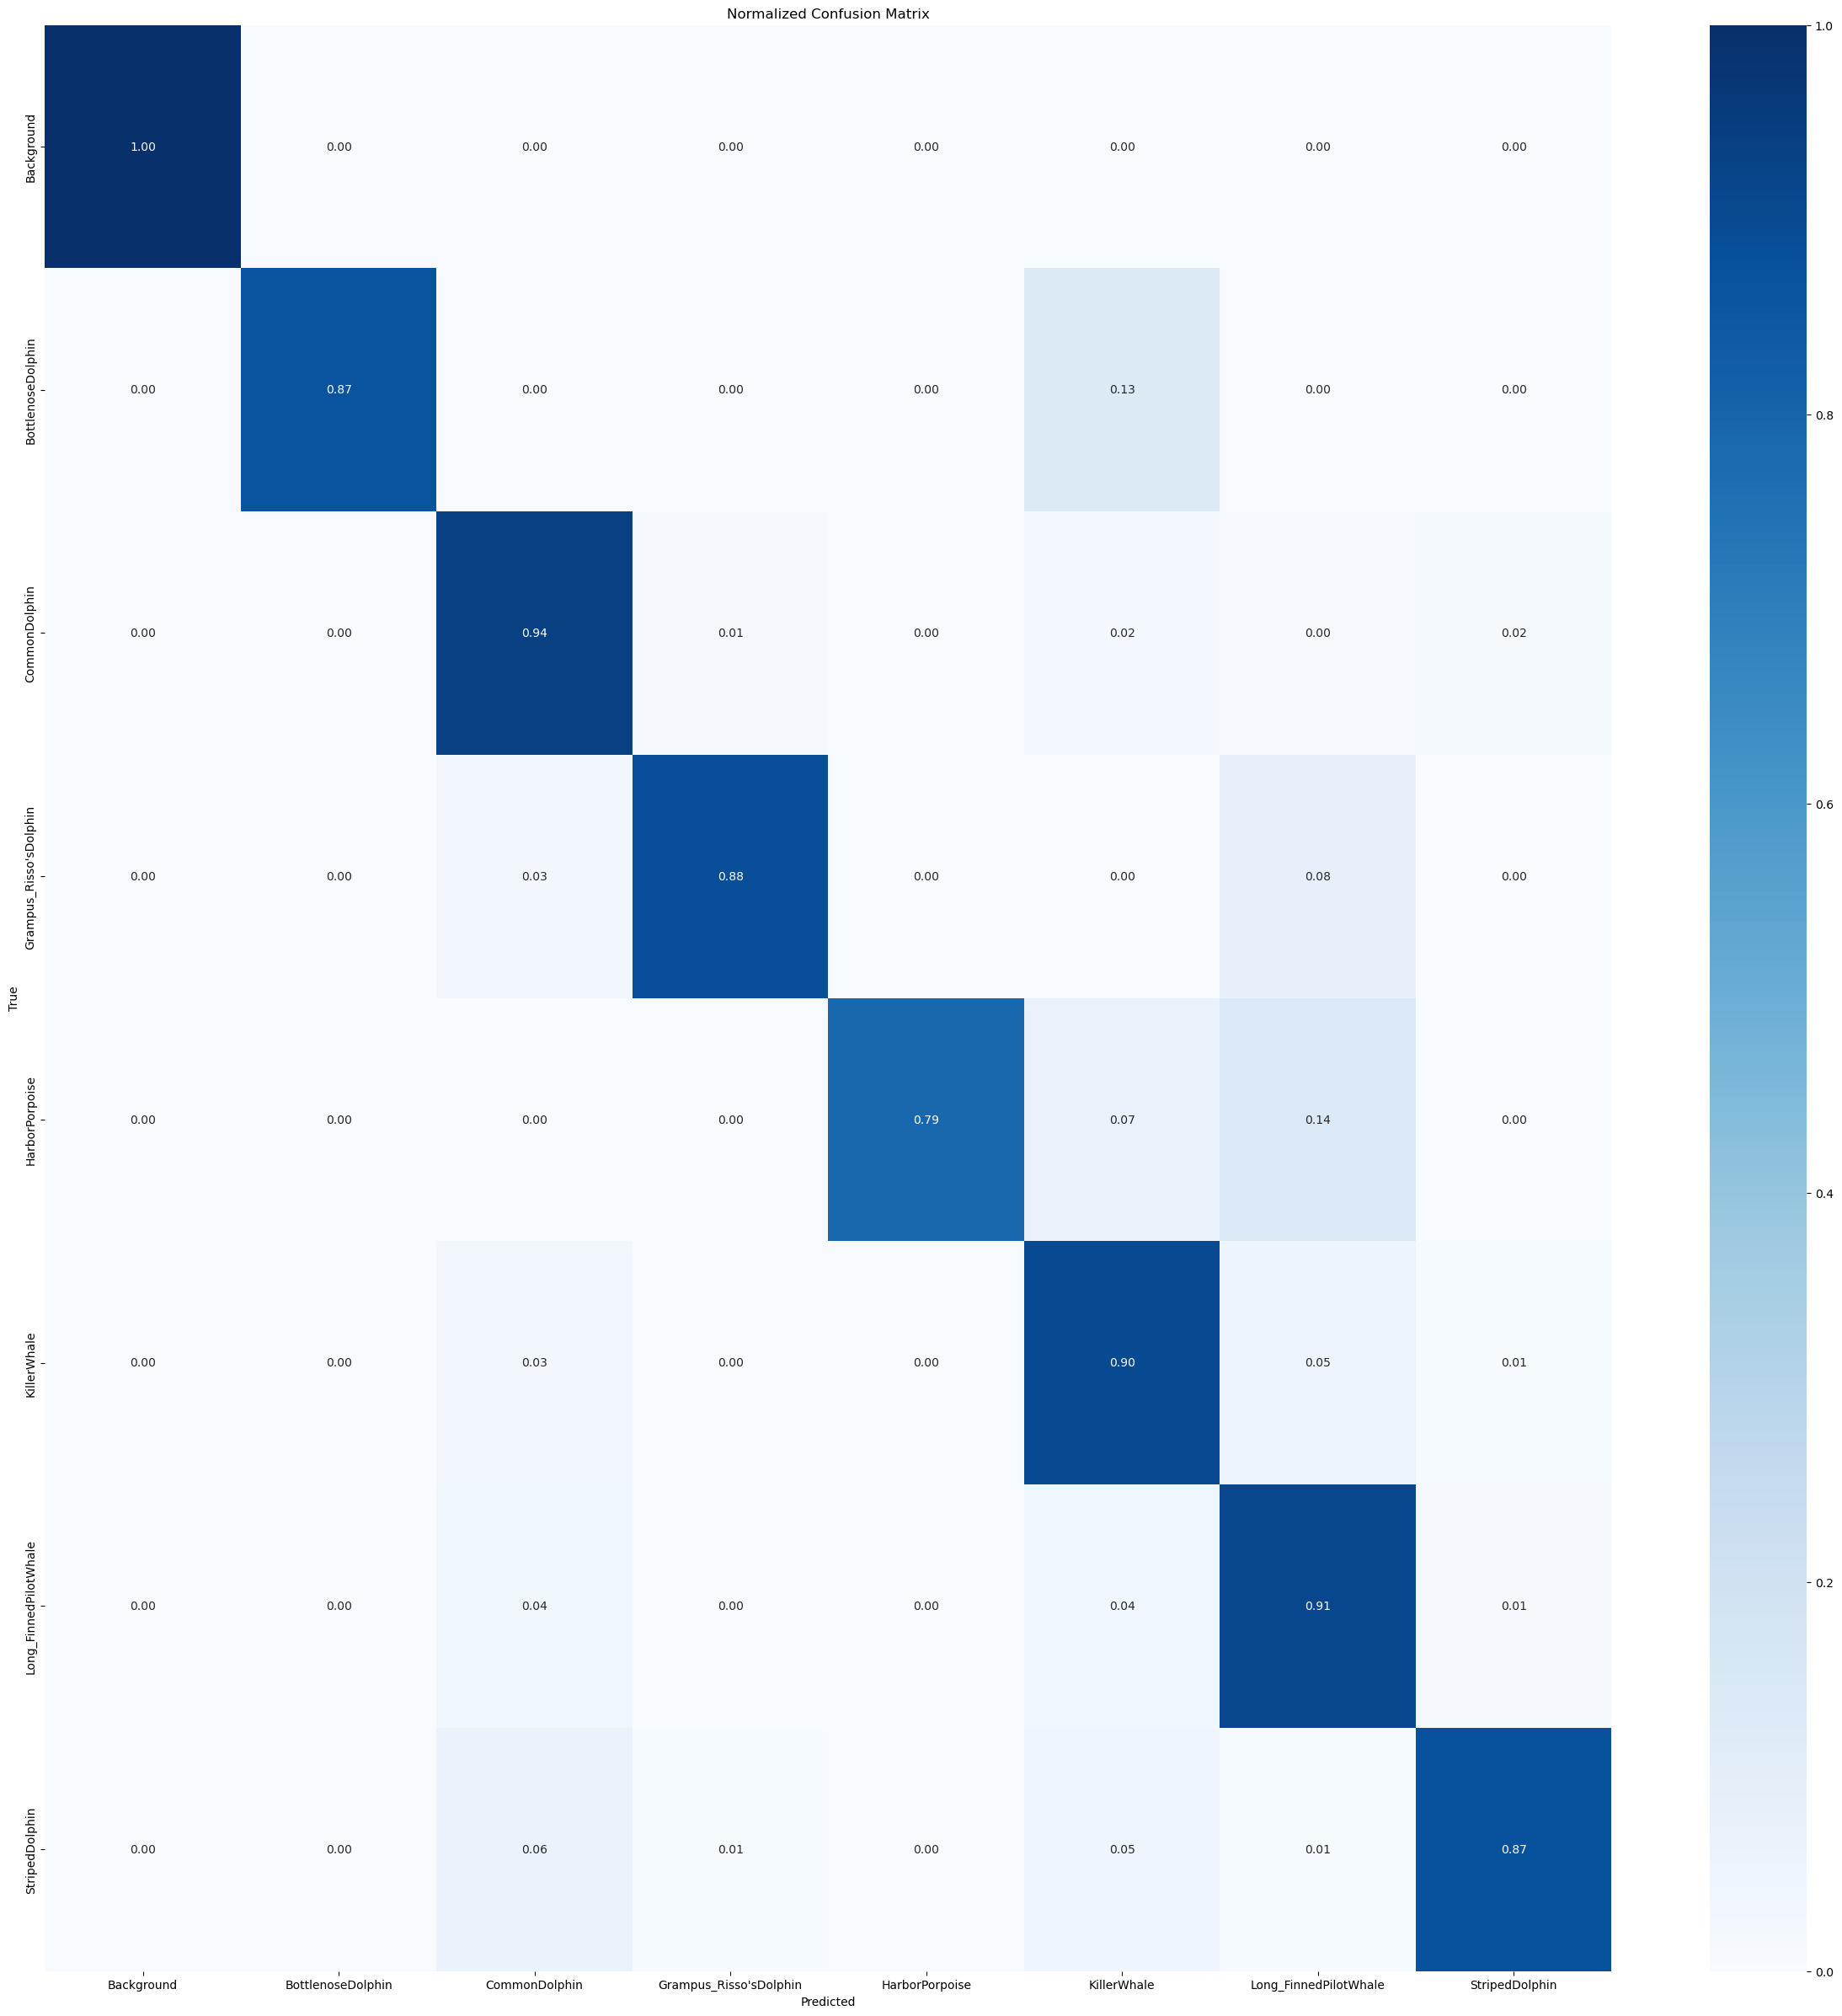

In [28]:
# from each prediction, take the class with the highest probability
pred_classes = [perch.classes[i] for i in preds.flatten()]

# Convert one-hot encoded test_labels to a list of class labels
true_classes = test_labels.idxmax(axis=1)  # Get class name with highest value (True)
# Generate classification report
report = classification_report(true_classes, pred_classes)
print(report)

# Plot confusion matrix
cm = confusion_matrix(true_classes, pred_classes, labels=test_labels.columns)
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_labels.columns, yticklabels=test_labels.columns)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Normalized by rows
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(30, 30))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=test_labels.columns, yticklabels=test_labels.columns)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [29]:
from sklearn.metrics import f1_score

accuracy = accuracy_score(true_classes, pred_classes)
print(f"Accuracy: {accuracy:.4f}")

macro_f1 = f1_score(true_classes, pred_classes, average="macro")
weighted_f1 = f1_score(true_classes, pred_classes, average="weighted")

print(f"Macro F1-score: {macro_f1:.4f}")
print(f"Weighted F1-score: {weighted_f1:.4f}")


from sklearn.metrics import roc_auc_score

# Assuming 'preds' contains raw probabilities from the classifier
auc_score = roc_auc_score(test_labels.values, preds, average="macro", multi_class="ovr")
print(f"Macro ROC-AUC Score: {auc_score:.4f}")


Accuracy: 0.9337
Macro F1-score: 0.9111
Weighted F1-score: 0.9339


ValueError: Expected 2D array, got 1D array instead:
array=[1 1 1 ... 6 6 6].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### Use perch embeddings with XGBoost

In [ ]:
# take a XGBoost classifier
from sklearn.ensemble import GradientBoostingClassifier

# create several experiments for classifier and select the best one in validation
n_estimators = [10, 50, 100]
max_depth = [10, 20, 50]
best_score = 0
best_clf = None

for n in n_estimators:
    for d in max_depth:
        clf = GradientBoostingClassifier(n_estimators=n, max_depth=d, random_state=42)
        clf.fit(emb_train, train_labels.values.argmax(axis=1))
        preds = clf.predict(emb_val)
        # score = macro average f1
        score = f1_score(val_labels.values.argmax(axis=1), preds, average='macro')
        if score > best_score:
            best_score = score
            best_clf = clf

# print the best parameters
print(best_clf)

# make predictions on the test set
preds = best_clf.predict(emb_test)

                        precision    recall  f1-score   support

            Background       1.00      1.00      1.00       584
     BottlenoseDolphin       1.00      0.87      0.93        30
         CommonDolphin       0.84      0.94      0.88       212
Grampus_Risso'sDolphin       0.93      0.88      0.91        60
        HarborPorpoise       1.00      0.79      0.88        14
           KillerWhale       0.95      0.90      0.92       532
 Long_FinnedPilotWhale       0.88      0.91      0.90       312
        StripedDolphin       0.87      0.87      0.87       110

              accuracy                           0.93      1854
             macro avg       0.93      0.89      0.91      1854
          weighted avg       0.94      0.93      0.93      1854



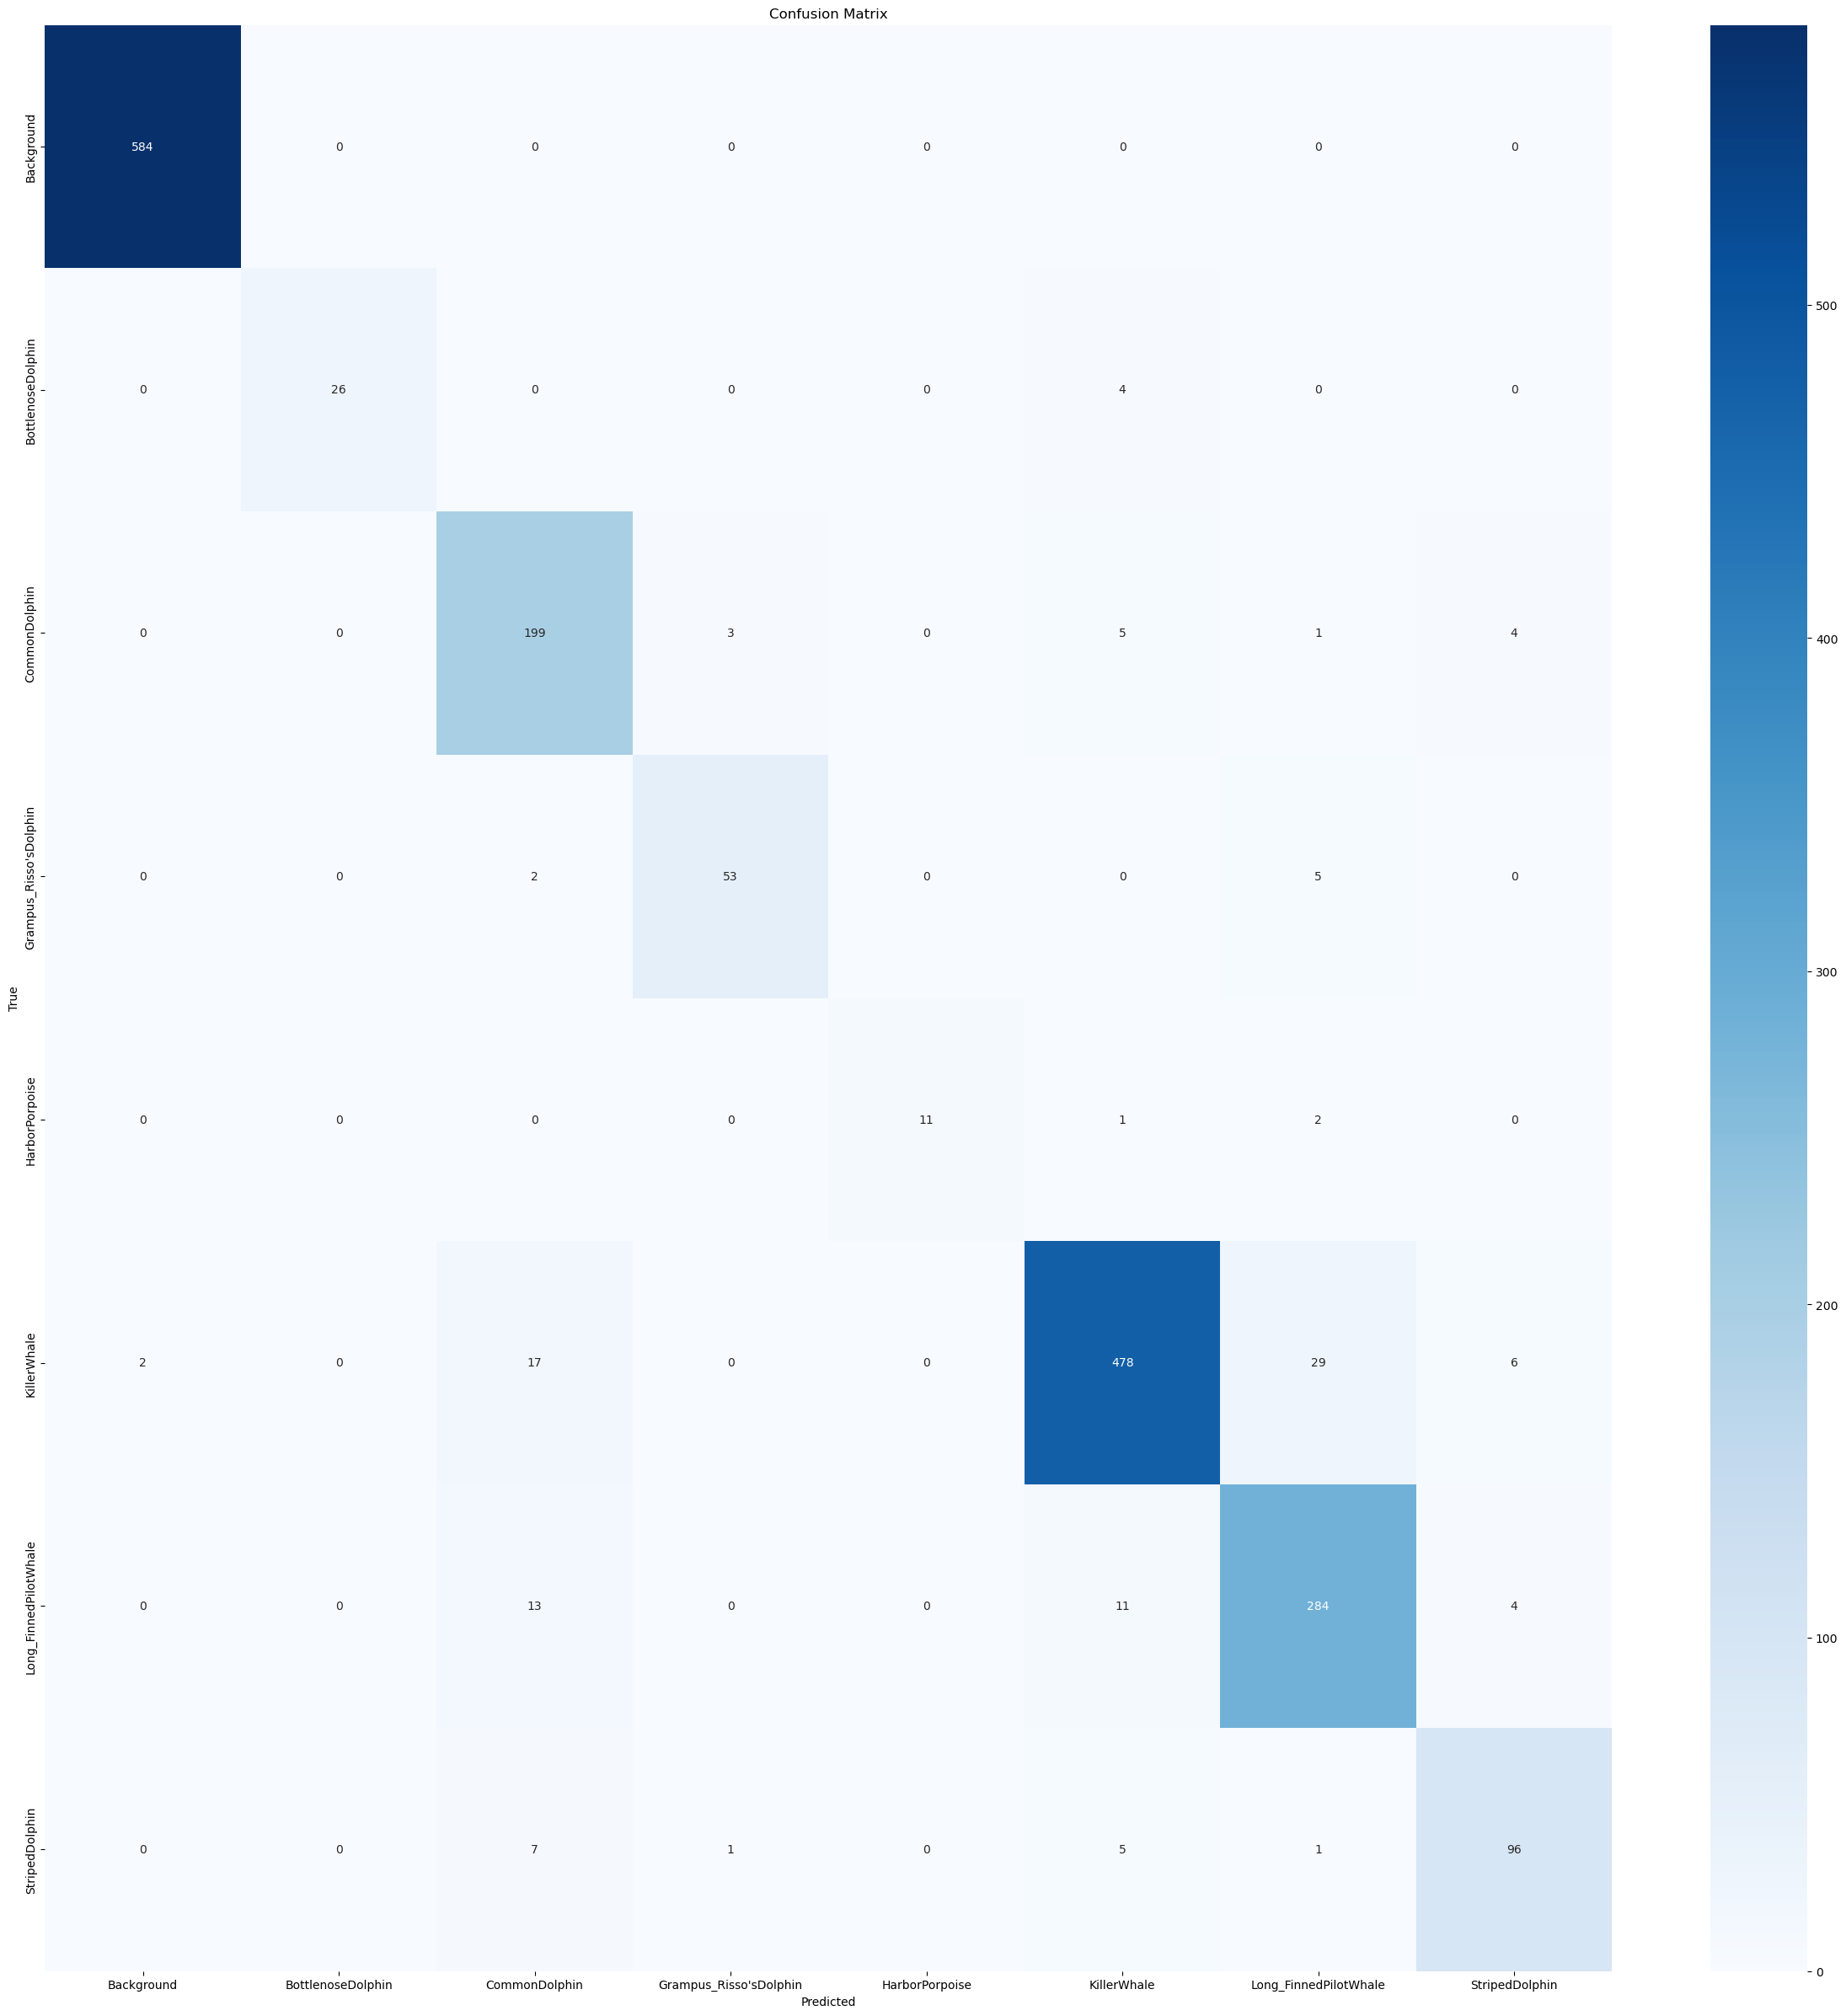

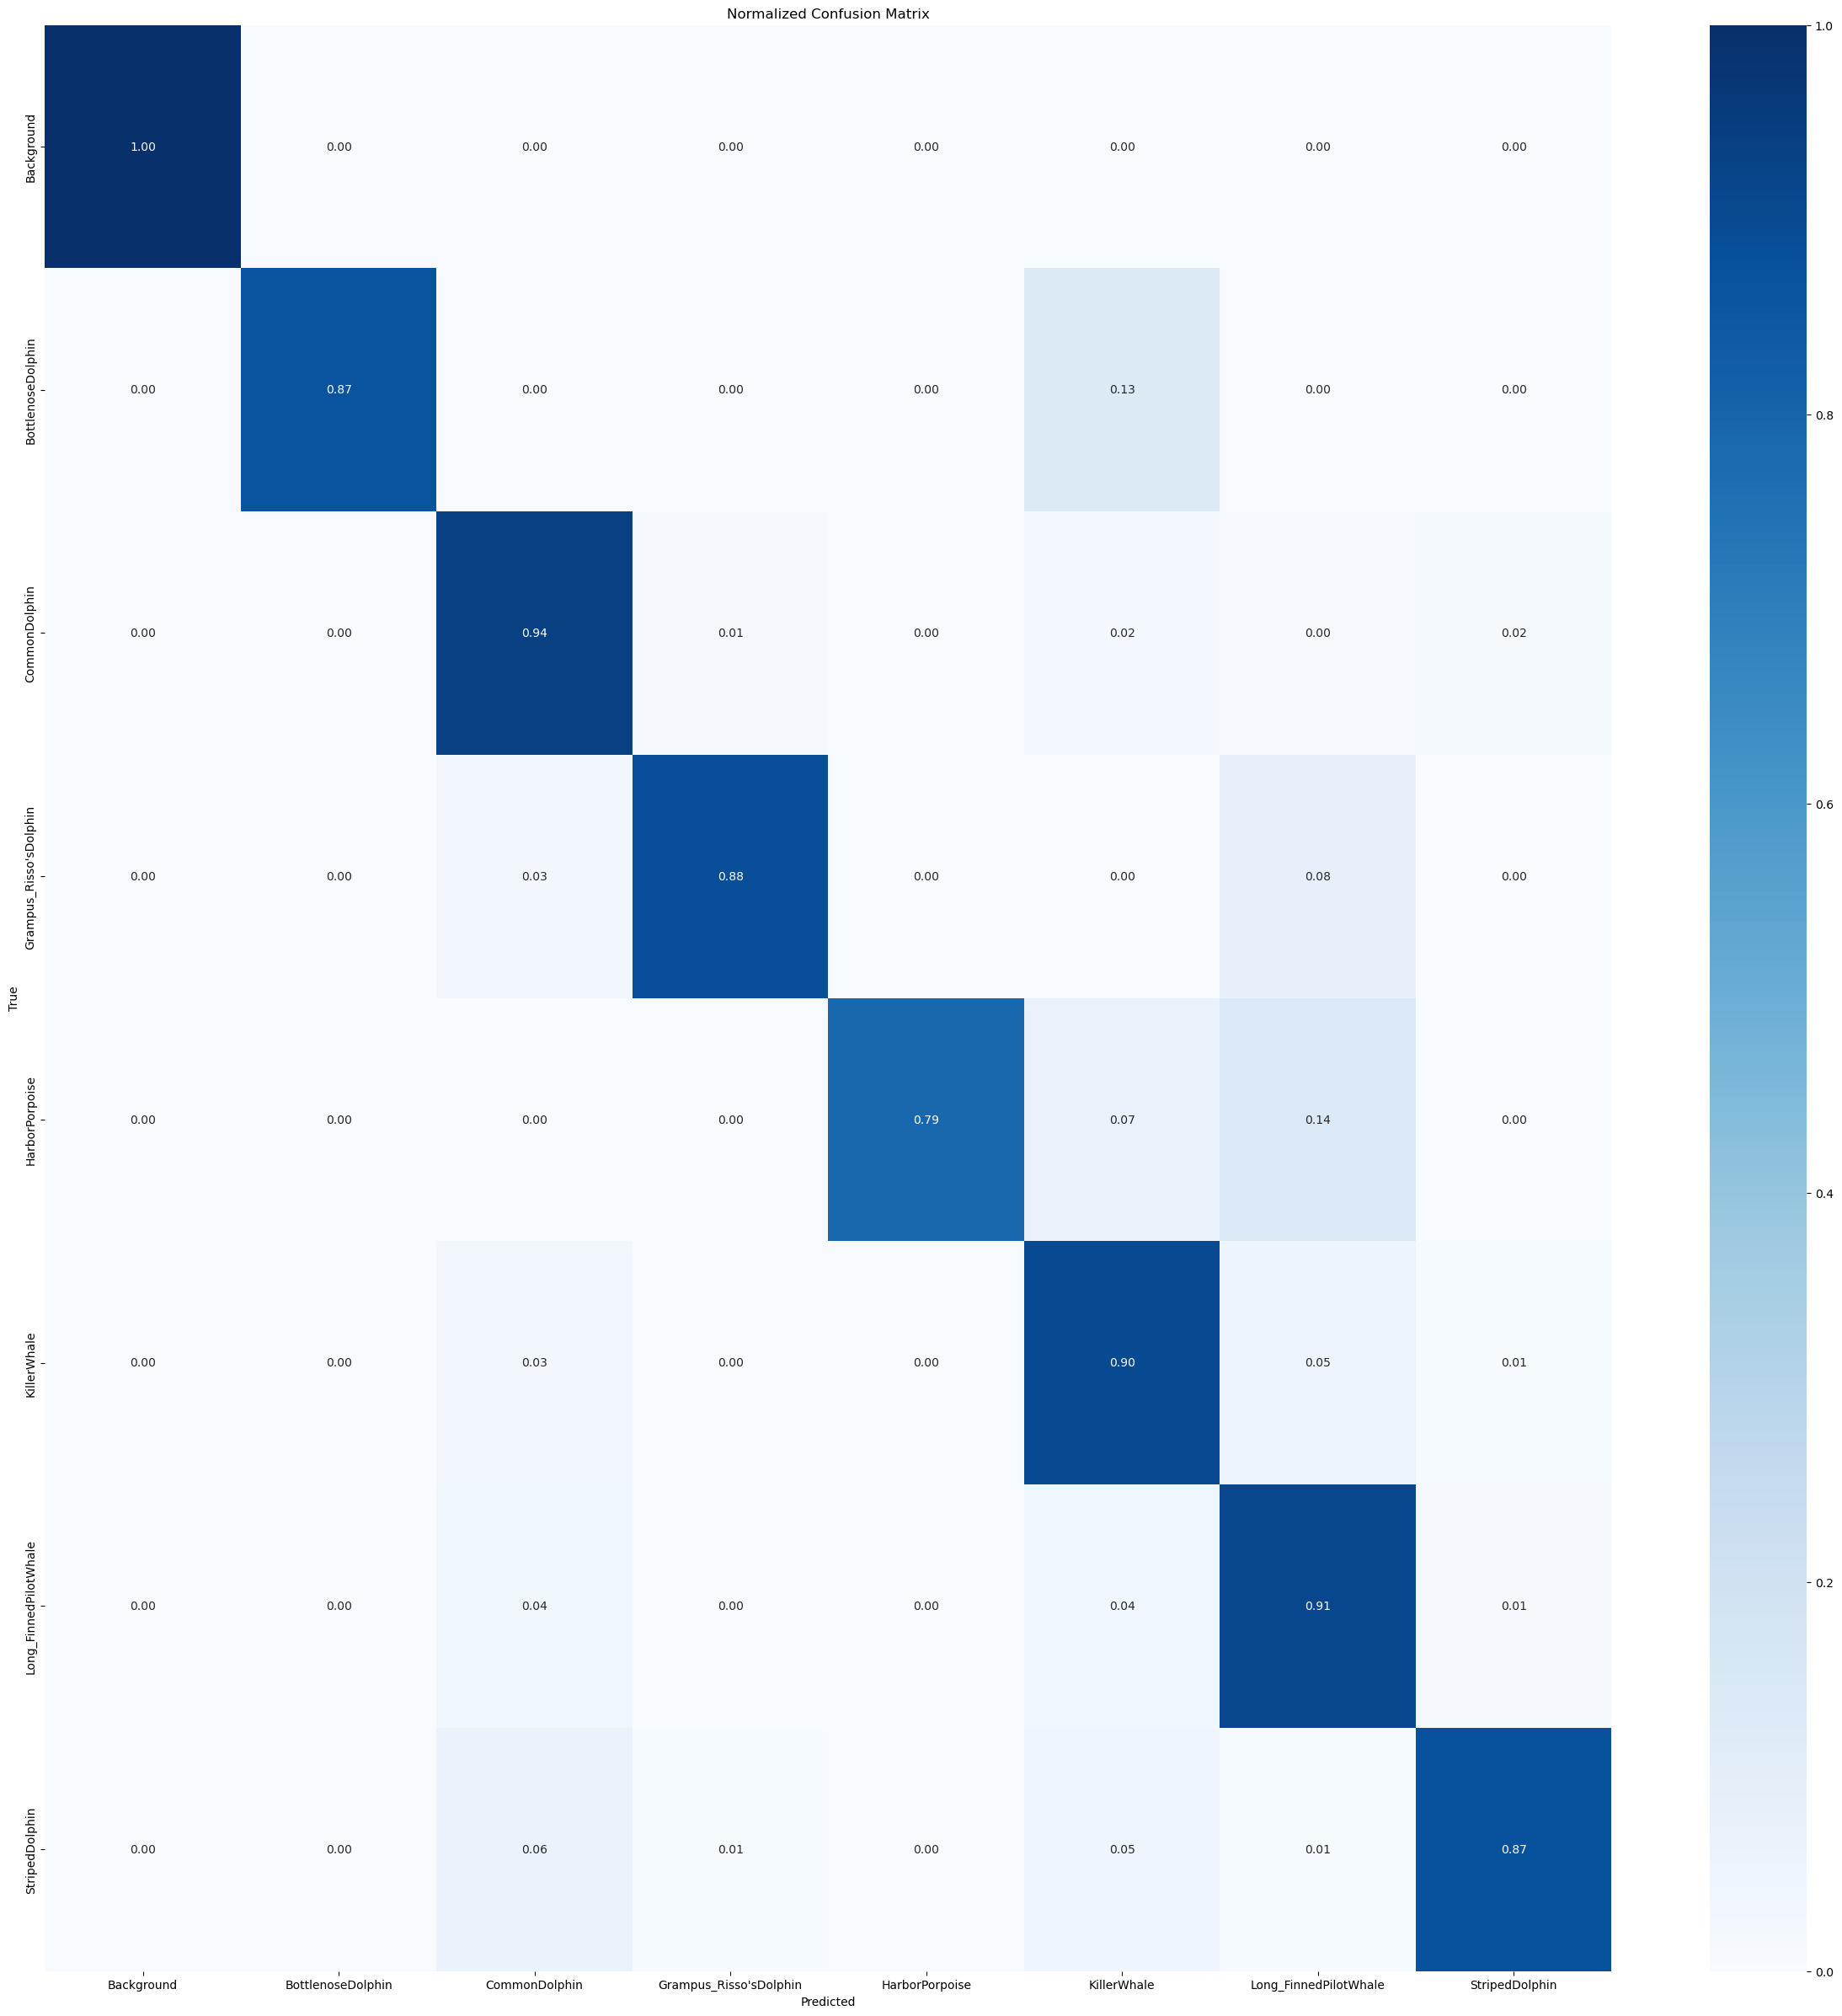

In [ ]:
# from each prediction, take the class with the highest probability
pred_classes = [perch.classes[i] for i in preds.flatten()]

# Convert one-hot encoded test_labels to a list of class labels
true_classes = test_labels.idxmax(axis=1)  # Get class name with highest value (True)
# Generate classification report
report = classification_report(true_classes, pred_classes)
print(report)

# Plot confusion matrix
cm = confusion_matrix(true_classes, pred_classes, labels=test_labels.columns)
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_labels.columns, yticklabels=test_labels.columns)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Normalized by rows
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(30, 30))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=test_labels.columns, yticklabels=test_labels.columns)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.metrics import f1_score

accuracy = accuracy_score(true_classes, pred_classes)
print(f"Accuracy: {accuracy:.4f}")

macro_f1 = f1_score(true_classes, pred_classes, average="macro")
weighted_f1 = f1_score(true_classes, pred_classes, average="weighted")

print(f"Macro F1-score: {macro_f1:.4f}")
print(f"Weighted F1-score: {weighted_f1:.4f}")


from sklearn.metrics import roc_auc_score

# Assuming 'preds' contains raw probabilities from the classifier
auc_score = roc_auc_score(test_labels.values, preds, average="macro", multi_class="ovr")
print(f"Macro ROC-AUC Score: {auc_score:.4f}")


Accuracy: 0.9337
Macro F1-score: 0.9111
Weighted F1-score: 0.9339
Macro ROC-AUC Score: 0.0008
